# Trenowanie CNN do Predykcji Wilgotności Gleby

Skrypt do trenowania splotowej sieci neuronowej (CNN) do predykcji 
wilgotności gleby z wielospektralnych zdjęć satelitarnych Planet Labs 
dla sieci REMEDHUS.


## 1. Import bibliotek

In [36]:
# Podstawowe biblioteki
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys
from datetime import datetime, timedelta
from pathlib import Path
import json
from collections import defaultdict
import warnings

# Geospatial
import rasterio
from rasterio.windows import Window
from rasterio.transform import rowcol

# Machine Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb

# Progress bars
from tqdm import tqdm

# Konfiguracja
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
np.random.seed(42)
tf.random.set_seed(42)

# Wyświetl informacje o środowisku
print("="*70)
print("WERYFIKACJA ŚRODOWISKA")
print("="*70)
print(f"Python version:      {sys.version.split()[0]}")
print(f"NumPy version:       {np.__version__}")
print(f"Pandas version:      {pd.__version__}")
print(f"TensorFlow version:  {tf.__version__}")
print(f"Rasterio version:    {rasterio.__version__}")

WERYFIKACJA ŚRODOWISKA
Python version:      3.12.3
NumPy version:       2.3.4
Pandas version:      2.3.3
TensorFlow version:  2.20.0
Rasterio version:    1.4.3


## 2. Konfiguracja
Klasa konfiguracyjna zawierająca wszystkie parametry projektu

In [10]:
class Config:
    # ==================== ŚCIEŻKI ====================
    CURRENT_DIR = os.getcwd()
    REM_DIR = os.path.join(CURRENT_DIR, "REMEDHUS-moisture", "REMEDHUS")
    SATELLITE_DIR = os.path.join(CURRENT_DIR, "data", "remedhus_timeseries")
    OUTPUT_DIR = os.path.join(CURRENT_DIR, "training_output")
    
    # ==================== WSPÓŁRZĘDNE STACJI REMEDHUS ====================
    # Źródło: ISMN (International Soil Moisture Network)
    # Obszar: Basen rzeki Duero, północno-zachodnia Hiszpania
    # Bounding box: 41.1-41.5°N, 5.1-5.7°W
    
    STATION_COORDS = {
        'Canizal': {'lat': 41.19603, 'lon': -5.35997, 'elevation': 795.7},
        'Carretoro': {'lat': 41.26504, 'lon': -5.38049, 'elevation': 740},
        'Casa_Periles': {'lat': 41.39392, 'lon': -5.32146, 'elevation': 748.5},
        'Concejo_del_Monte': {'lat': 41.30010, 'lon': -5.24704, 'elevation': 762.3},
        'El_Coto': {'lat': 41.38134, 'lon': -5.42922, 'elevation': 727.2},

        'El_Tomillar': {'lat': 41.34888, 'lon': -5.49027, 'elevation': 762},
        'Granja_g': {'lat': 41.30582, 'lon': -5.37566, 'elevation': 704.5},
        'Guarrati': {'lat': 41.28920, 'lon': -5.46713, 'elevation': 739},
        'La_Atalaya': {'lat': 41.14894, 'lon': -5.39757, 'elevation': 825.0},
        'La_Cruz_de_Elias': {'lat': 41.28546, 'lon': -5.30003, 'elevation': 796},
        
        'Las_Arenas': {'lat': 41.37338, 'lon': -5.54850, 'elevation': 744.8},
        'Las_Bodegas': {'lat': 41.18264, 'lon': -5.47708, 'elevation': 902.3},
        'Las_Brozas': {'lat': 41.44649, 'lon': -5.35870, 'elevation': 681.4},
        'Las_Eritas': {'lat': 41.20548, 'lon': -5.41558, 'elevation': 834.7},
        'Las_Tres_Rayas': {'lat': 41.27473, 'lon': -5.59190 , 'elevation': 876.9},
        
        'Las_Vacas': {'lat': 41.34709, 'lon': -5.22474, 'elevation': 760.1},
        'Las_Victorias': {'lat': 41.42413, 'lon': -5.37403 , 'elevation': 742.9},
        'Llanos_de_la_Boveda': {'lat': 41.35757, 'lon': -5.33113, 'elevation': 803.7},
        'Paredinas': {'lat': 41.45586, 'lon': -5.41100 , 'elevation': 667.5},
        'Zamarron': {'lat': 41.23923, 'lon': -5.54427, 'elevation': 848.9},
    }
    
    # ==================== PARAMETRY DATASETU ====================
    PATCH_SIZE = 64          # Rozmiar wycinka wokół stacji (piksele)
    NUM_BANDS = 8            # Kanały Planet Labs (B,G,R,NIR,RE1-4)
    TIME_TOLERANCE_HOURS = 3  # Dopasowanie czasowe ±3h
    MIN_VALID_PIXELS = 0.8   # Min. % ważnych pikseli w patchu
    
    # ==================== HIPERPARAMETRY CNN ====================
    BATCH_SIZE = 32
    EPOCHS = 100
    LEARNING_RATE = 0.001
    VALIDATION_SPLIT = 0.15
    TEST_SPLIT = 0.15
    
    # Augmentacja (opcjonalnie)
    USE_AUGMENTATION = False
    AUGMENTATION_PARAMS = {
        'rotation_range': 15,
        'horizontal_flip': True,
        'vertical_flip': True,
        'brightness_range': [0.9, 1.1]
    }
    
    # ==================== CALLBACKS ====================
    EARLY_STOPPING_PATIENCE = 15
    REDUCE_LR_PATIENCE = 5
    REDUCE_LR_FACTOR = 0.5
    MIN_LR = 1e-7
    
    # ==================== METRYKI ====================
    METRICS = ['mae', 'mse', tf.keras.metrics.RootMeanSquaredError(name='rmse')]
    
    # ==================== EXPORT ====================
    SAVE_BEST_ONLY = True
    SAVE_FREQUENCY = 'epoch'
    EXPORT_FORMATS = ['h5', 'savedmodel', 'tflite']


# Utwórz instancję konfiguracji
config = Config()

# Utwórz katalog wyjściowy
os.makedirs(config.OUTPUT_DIR, exist_ok=True)

# Wyświetl podsumowanie konfiguracji
print("="*70)
print("KONFIGURACJA PROJEKTU")
print("="*70)
print(f"Katalog danych REMEDHUS:  {config.REM_DIR}")
print(f"Katalog danych satelitarnych: {config.SATELLITE_DIR}")
print(f"Katalog wyjściowy:        {config.OUTPUT_DIR}")
print(f"\nLiczba stacji:            {len(config.STATION_COORDS)}")
print(f"Rozmiar patcha:           {config.PATCH_SIZE}×{config.PATCH_SIZE} px")
print(f"Liczba kanałów:           {config.NUM_BANDS}")
print(f"Tolerancja czasowa:       ±{config.TIME_TOLERANCE_HOURS}h")
print(f"\nBatch size:               {config.BATCH_SIZE}")
print(f"Liczba epok:              {config.EPOCHS}")
print(f"Learning rate:            {config.LEARNING_RATE}")
print(f"Validation split:         {config.VALIDATION_SPLIT*100:.0f}%")
print(f"Test split:               {config.TEST_SPLIT*100:.0f}%")
print("="*70)

print("\n✅ Konfiguracja załadowana!\n")

KONFIGURACJA PROJEKTU
Katalog danych REMEDHUS:  /home/jbktn/inzynierka/REMEDHUS-moisture/REMEDHUS
Katalog danych satelitarnych: /home/jbktn/inzynierka/data/remedhus_timeseries
Katalog wyjściowy:        /home/jbktn/inzynierka/training_output

Liczba stacji:            20
Rozmiar patcha:           64×64 px
Liczba kanałów:           8
Tolerancja czasowa:       ±3h

Batch size:               32
Liczba epok:              100
Learning rate:            0.001
Validation split:         15%
Test split:               15%

✅ Konfiguracja załadowana!



### Funkcje pomocnicze

In [11]:
def print_section(title):
    """Wyświetl nagłówek sekcji"""
    print("\n" + "="*70)
    print(f"  {title}")
    print("="*70 + "\n")


def format_bytes(size):
    """Konwertuj bajty na czytelny format"""
    for unit in ['B', 'KB', 'MB', 'GB', 'TB']:
        if size < 1024.0:
            return f"{size:.2f} {unit}"
        size /= 1024.0


def check_directory(path, create=True):
    """Sprawdź czy katalog istnieje, opcjonalnie utwórz"""
    if not os.path.exists(path):
        if create:
            os.makedirs(path, exist_ok=True)
            print(f"✓ Utworzono katalog: {path}")
            return True
        else:
            print(f"✗ Katalog nie istnieje: {path}")
            return False
    else:
        print(f"✓ Katalog istnieje: {path}")
        return True


def log_to_file(message, filename='process.log'):
    """Zapisz wiadomość do pliku logu"""
    log_path = os.path.join(config.OUTPUT_DIR, filename)
    timestamp = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    with open(log_path, 'a') as f:
        f.write(f"[{timestamp}] {message}\n")


class Timer:
    """Prosty timer do mierzenia czasu wykonania"""
    def __init__(self, name="Operation"):
        self.name = name
        self.start_time = None
    
    def __enter__(self):
        self.start_time = datetime.now()
        print(f"⏱️  Rozpoczęto: {self.name}...")
        return self
    
    def __exit__(self, *args):
        elapsed = datetime.now() - self.start_time
        print(f"✓ Zakończono: {self.name} w {elapsed}")
        log_to_file(f"{self.name}: {elapsed}")


# Test funkcji pomocniczych
print_section("FUNKCJE POMOCNICZE - TEST")

# Test sprawdzania katalogów
check_directory(config.REM_DIR, create=False)
check_directory(config.SATELLITE_DIR, create=False)
check_directory(config.OUTPUT_DIR, create=True)

# Test timera
with Timer("Test operacji"):
    import time
    time.sleep(0.5)

print("\n✅ Funkcje pomocnicze załadowane!\n")



  FUNKCJE POMOCNICZE - TEST

✓ Katalog istnieje: /home/jbktn/inzynierka/REMEDHUS-moisture/REMEDHUS
✓ Katalog istnieje: /home/jbktn/inzynierka/data/remedhus_timeseries
✓ Katalog istnieje: /home/jbktn/inzynierka/training_output
⏱️  Rozpoczęto: Test operacji...
✓ Zakończono: Test operacji w 0:00:00.500233

✅ Funkcje pomocnicze załadowane!



## 3. Wczytywanie danych wilgotności ze stacji REMEDHUS
Wczytywanie i parsowanie danych wilgotności z plików .stm sieci REMEDHUS

In [12]:
def load_moisture_data(rem_dir, verbose=True):
    """
    Wczytuje dane wilgotności ze wszystkich stacji REMEDHUS
    
    Format pliku .stm:
    Linia 1 (nagłówek): REMEDHUS REMEDHUS Canizal 41.19603 -5.35997 ...
    Linia 2+: YYYY/MM/DD HH:MM moisture quality_code flag
    
    Przykład:
    2015/01/01 00:00 0.267 D03 M
    
    Args:
        rem_dir (str): Ścieżka do katalogu REMEDHUS
        verbose (bool): Czy wyświetlać szczegółowe informacje
    
    Returns:
        pd.DataFrame: DataFrame z kolumnami [station, datetime, moisture, quality_flag, year, month, day, hour]
    """
    
    if verbose:
        print_section("WCZYTYWANIE DANYCH WILGOTNOŚCI")
    
    all_data = []
    error_count = 0
    files_processed = 0
    files_found = 0
    
    # Sprawdź czy katalog istnieje
    if not os.path.exists(rem_dir):
        raise FileNotFoundError(f"Katalog REMEDHUS nie istnieje: {rem_dir}")
    
    # Znajdź wszystkie katalogi stacji
    locations = [f for f in os.listdir(rem_dir) 
                 if os.path.isdir(os.path.join(rem_dir, f))]
    
    if verbose:
        print(f"Znaleziono {len(locations)} katalogów stacji")
        print(f"Katalogi: {', '.join(sorted(locations))}\n")
    
    if len(locations) == 0:
        print(f"⚠️  BŁĄD: Brak katalogów w {rem_dir}")
        return pd.DataFrame()
    
    # Progress bar
    pbar = tqdm(locations, desc="Wczytywanie stacji", disable=not verbose)
    
    for location in pbar:
        location_path = os.path.join(rem_dir, location)
        
        if not os.path.isdir(location_path):
            continue
        
        # Znajdź pliki .stm
        data_files = [f for f in os.listdir(location_path) if f.endswith('.stm')]
        files_found += len(data_files)
        
        pbar.set_postfix({'station': location, 'files': len(data_files)})
        
        for data_file in data_files:
            file_path = os.path.join(location_path, data_file)
            files_processed += 1
            
            try:
                with open(file_path, 'r') as file:
                    lines = file.readlines()
                
                if len(lines) <= 1:
                    continue
                
                # Debug: Wyświetl przykład z pierwszego pliku
                if files_processed == 1 and verbose:
                    print(f"\n📄 Przykładowy format pliku {data_file}:")
                    print(f"   Nagłówek: {lines[0].strip()}")
                    if len(lines) > 1:
                        print(f"   Pierwsza linia danych: {lines[1].strip()}")
                        parts = lines[1].strip().split()
                        print(f"   Liczba kolumn: {len(parts)}")
                        print(f"   Kolumny: {parts}")
                    print()
                
                # Pomijamy nagłówek (pierwsza linia)
                data_lines = lines[1:]
                
                for line_num, line in enumerate(data_lines, start=2):
                    line = line.strip()
                    
                    if not line:
                        continue
                    
                    parts = line.split()
                    
                    # Format REMEDHUS: YYYY/MM/DD HH:MM moisture quality_code flag
                    # Minimalna liczba kolumn: 3 (data, czas, wilgotność)
                    if len(parts) < 3:
                        error_count += 1
                        continue
                    
                    try:
                        # Parsowanie
                        date_str = parts[0]
                        time_str = parts[1]
                        moisture = float(parts[2])
                        
                        # Opcjonalnie: kod jakości i flaga
                        quality_code = parts[3] if len(parts) >= 4 else None
                        flag = parts[4] if len(parts) >= 5 else None
                        
                        # Walidacja wilgotności (m³/m³)
                        if moisture <= 0 or moisture > 1.0:
                            error_count += 1
                            continue
                        
                        # Parsowanie daty
                        try:
                            timestamp = datetime.strptime(
                                f"{date_str} {time_str}", 
                                "%Y/%m/%d %H:%M"
                            )
                        except ValueError:
                            error_count += 1
                            continue
                        
                        all_data.append({
                            'station': location,
                            'datetime': timestamp,
                            'moisture': moisture,
                            'quality_code': quality_code,
                            'flag': flag,
                            'year': timestamp.year,
                            'month': timestamp.month,
                            'day': timestamp.day,
                            'hour': timestamp.hour
                        })
                        
                    except (ValueError, IndexError) as e:
                        error_count += 1
                        continue
                        
            except Exception as e:
                if verbose:
                    print(f"\n❌ Błąd wczytywania {file_path}: {e}")
                continue
    
    pbar.close()
    
    # Diagnostyka
    if verbose:
        print(f"\n📊 Diagnostyka:")
        print(f"   Katalogów stacji: {len(locations)}")
        print(f"   Znalezionych plików .stm: {files_found}")
        print(f"   Przetworzonych plików: {files_processed}")
        print(f"   Wczytanych rekordów: {len(all_data):,}")
        print(f"   Odrzuconych rekordów: {error_count:,}")
    
    # Sprawdź czy są jakiekolwiek dane
    if len(all_data) == 0:
        print("\n❌ BŁĄD: Nie wczytano żadnych danych!")
        print("\nMożliwe przyczyny:")
        print("1. Brak plików .stm w katalogach stacji")
        print("2. Nieprawidłowy format danych w plikach")
        print("3. Wszystkie wartości zostały odrzucone przez walidację")
        
        return pd.DataFrame()
    
    # Konwersja do DataFrame
    df = pd.DataFrame(all_data)
    
    if verbose:
        print(f"\n✅ Wczytano {len(df):,} poprawnych pomiarów")
        print(f"   Stacji: {df['station'].nunique()}")
        print(f"   Zakres dat: {df['datetime'].min()} - {df['datetime'].max()}")
        
        # Statystyki
        print("\nStatystyki wilgotności:")
        print(df['moisture'].describe())
        
        # Statystyki kodów jakości
        if 'quality_code' in df.columns:
            print(f"\nKody jakości:")
            quality_counts = df['quality_code'].value_counts()
            for code, count in quality_counts.head(5).items():
                print(f"   {code}: {count:,} ({count/len(df)*100:.1f}%)")
        
        # Statystyki per stacja
        print(f"\nPomiary per stacja (top 10):")
        station_counts = df['station'].value_counts().head(10)
        for station, count in station_counts.items():
            print(f"   {station}: {count:,} pomiarów")
        
        if df['station'].nunique() > 10:
            print(f"   ... i {df['station'].nunique() - 10} więcej stacji")
    
    return df


# ==================== WCZYTYWANIE ====================

# Wczytaj dane
with Timer("Wczytywanie danych REMEDHUS"):
    moisture_df = load_moisture_data(config.REM_DIR, verbose=True)

# Sprawdź czy DataFrame nie jest pusty
if moisture_df.empty:
    print("\n⚠️  UWAGA: DataFrame jest pusty!")
    print("Nie można kontynuować bez danych wilgotności.")
else:
    # Zapisz do pliku CSV
    csv_path = os.path.join(config.OUTPUT_DIR, 'moisture_data.csv')
    moisture_df.to_csv(csv_path, index=False)
    print(f"\n📄 Dane zapisane: {csv_path}")
    
    # Wyświetl przykładowe dane
    print("\n📋 Przykładowe rekordy:")
    print(moisture_df.head(10))

⏱️  Rozpoczęto: Wczytywanie danych REMEDHUS...

  WCZYTYWANIE DANYCH WILGOTNOŚCI

Znaleziono 20 katalogów stacji
Katalogi: Canizal, Carretoro, CasaPeriles, ConcejodelMonte, ElCoto, ElTomillar, Granja-g, Guarrati, LaAtalaya, LaCruzdeElias, LasArenas, LasBodegas, LasBrozas, LasEritas, LasTresRayas, LasVacas, LasVictorias, LlanosdelaBoveda, Paredinas, Zamarron



Wczytywanie stacji:   0%|          | 0/20 [00:00<?, ?it/s, station=Carretoro, files=1]


📄 Przykładowy format pliku REMEDHUS_REMEDHUS_Carretoro_sm_0.000000_0.050000_Stevens-Hydra-Probe_20150101_20250101.stm:
   Nagłówek: REMEDHUS   REMEDHUS   Carretoro       41.26504 -5.38049                 -99.9 0.0000 0.0500 Stevens Hydra Probe
   Pierwsza linia danych: 2015/01/01 00:00 0.074 D03 M
   Liczba kolumn: 5
   Kolumny: ['2015/01/01', '00:00', '0.074', 'D03', 'M']



Wczytywanie stacji: 100%|██████████| 20/20 [00:11<00:00,  1.68it/s, station=LasTresRayas, files=1]   



📊 Diagnostyka:
   Katalogów stacji: 20
   Znalezionych plików .stm: 20
   Przetworzonych plików: 20
   Wczytanych rekordów: 1,578,688
   Odrzuconych rekordów: 44,033

✅ Wczytano 1,578,688 poprawnych pomiarów
   Stacji: 20
   Zakres dat: 2015-01-01 00:00:00 - 2025-01-01 00:00:00

Statystyki wilgotności:
count    1.578688e+06
mean     1.296716e-01
std      1.059005e-01
min      1.000000e-04
25%      4.600000e-02
50%      1.063000e-01
75%      1.910000e-01
max      9.910000e-01
Name: moisture, dtype: float64

Kody jakości:
   G: 1,536,814 (97.3%)
   D03: 16,150 (1.0%)
   D05: 10,833 (0.7%)
   C03: 5,826 (0.4%)
   C02,C03: 5,153 (0.3%)

Pomiary per stacja (top 10):
   LasEritas: 87,306 pomiarów
   CasaPeriles: 86,870 pomiarów
   Guarrati: 86,696 pomiarów
   Zamarron: 86,632 pomiarów
   LaCruzdeElias: 86,350 pomiarów
   LlanosdelaBoveda: 85,958 pomiarów
   LasVacas: 85,947 pomiarów
   LasArenas: 85,947 pomiarów
   ConcejodelMonte: 85,831 pomiarów
   Canizal: 85,684 pomiarów
   ... i 10 wię

In [13]:
print_section("ANALIZA EKSPLORACYJNA DANYCH (EDA)")

# 1. Podstawowe statystyki per stacja
print("1️⃣  Statystyki per stacja:\n")
station_stats = moisture_df.groupby('station').agg({
    'moisture': ['count', 'mean', 'std', 'min', 'max'],
    'datetime': ['min', 'max']
}).round(3)

station_stats.columns = ['_'.join(col).strip() for col in station_stats.columns.values]
station_stats = station_stats.rename(columns={
    'moisture_count': 'n_measurements',
    'moisture_mean': 'mean_moisture',
    'moisture_std': 'std_moisture',
    'moisture_min': 'min_moisture',
    'moisture_max': 'max_moisture',
    'datetime_min': 'first_date',
    'datetime_max': 'last_date'
})

print(station_stats.head(10))

# Zapisz statystyki
stats_path = os.path.join(config.OUTPUT_DIR, 'station_statistics.csv')
station_stats.to_csv(stats_path)
print(f"\n📄 Statystyki zapisane: {stats_path}")

# 2. Rozkład pomiarów w czasie
print("\n2️⃣  Rozkład pomiarów w czasie:")
time_dist = moisture_df.groupby('year')['moisture'].count()
print(time_dist)

# 3. Sprawdź kompletność danych
print("\n3️⃣  Kompletność danych:")
total_stations = len(config.STATION_COORDS)
active_stations = moisture_df['station'].nunique()
print(f"   Stacji w konfiguracji: {total_stations}")
print(f"   Stacji z danymi: {active_stations}")

missing_stations = set(config.STATION_COORDS.keys()) - set(moisture_df['station'].unique())
if missing_stations:
    print(f"   ⚠️  Brak danych dla stacji: {', '.join(sorted(missing_stations))}")
else:
    print(f"   ✅ Wszystkie stacje mają dane")

# 4. Identyfikacja wartości odstających
print("\n4️⃣  Wartości odstające (outliers):")
Q1 = moisture_df['moisture'].quantile(0.25)
Q3 = moisture_df['moisture'].quantile(0.75)
IQR = Q3 - Q1
outliers = moisture_df[
    (moisture_df['moisture'] < Q1 - 1.5*IQR) | 
    (moisture_df['moisture'] > Q3 + 1.5*IQR)
]
print(f"   Znaleziono {len(outliers)} outlierów ({len(outliers)/len(moisture_df)*100:.2f}%)")
print(f"   Zakres normalny: [{Q1 - 1.5*IQR:.3f}, {Q3 + 1.5*IQR:.3f}]")



  ANALIZA EKSPLORACYJNA DANYCH (EDA)

1️⃣  Statystyki per stacja:

                 n_measurements  mean_moisture  std_moisture  min_moisture  \
station                                                                      
Canizal                   85684          0.226         0.084         0.030   
Carretoro                 82102          0.052         0.037         0.000   
CasaPeriles               86870          0.121         0.051         0.037   
ConcejodelMonte           85831          0.181         0.075         0.030   
ElCoto                    79142          0.035         0.020         0.001   
ElTomillar                73431          0.030         0.022         0.000   
Granja-g                  84293          0.098         0.062         0.001   
Guarrati                  86696          0.293         0.169         0.050   
LaAtalaya                 24584          0.105         0.069         0.001   
LaCruzdeElias             86350          0.151         0.074         0.001


  WIZUALIZACJE DANYCH WILGOTNOŚCI



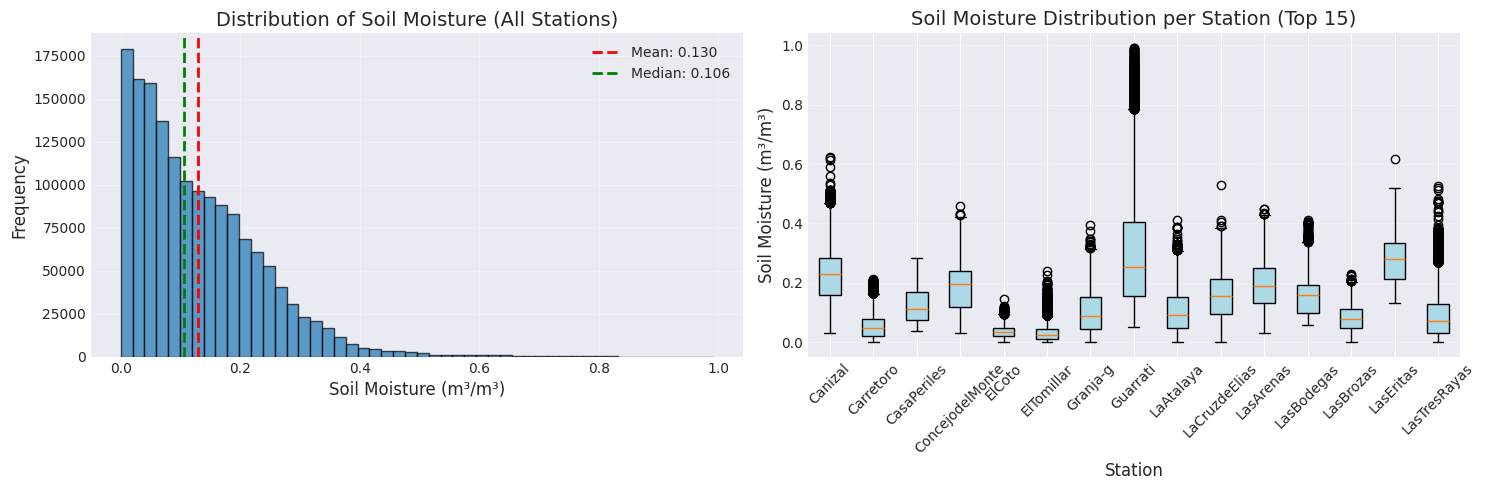

✓ Wykres 1: Rozkład wilgotności


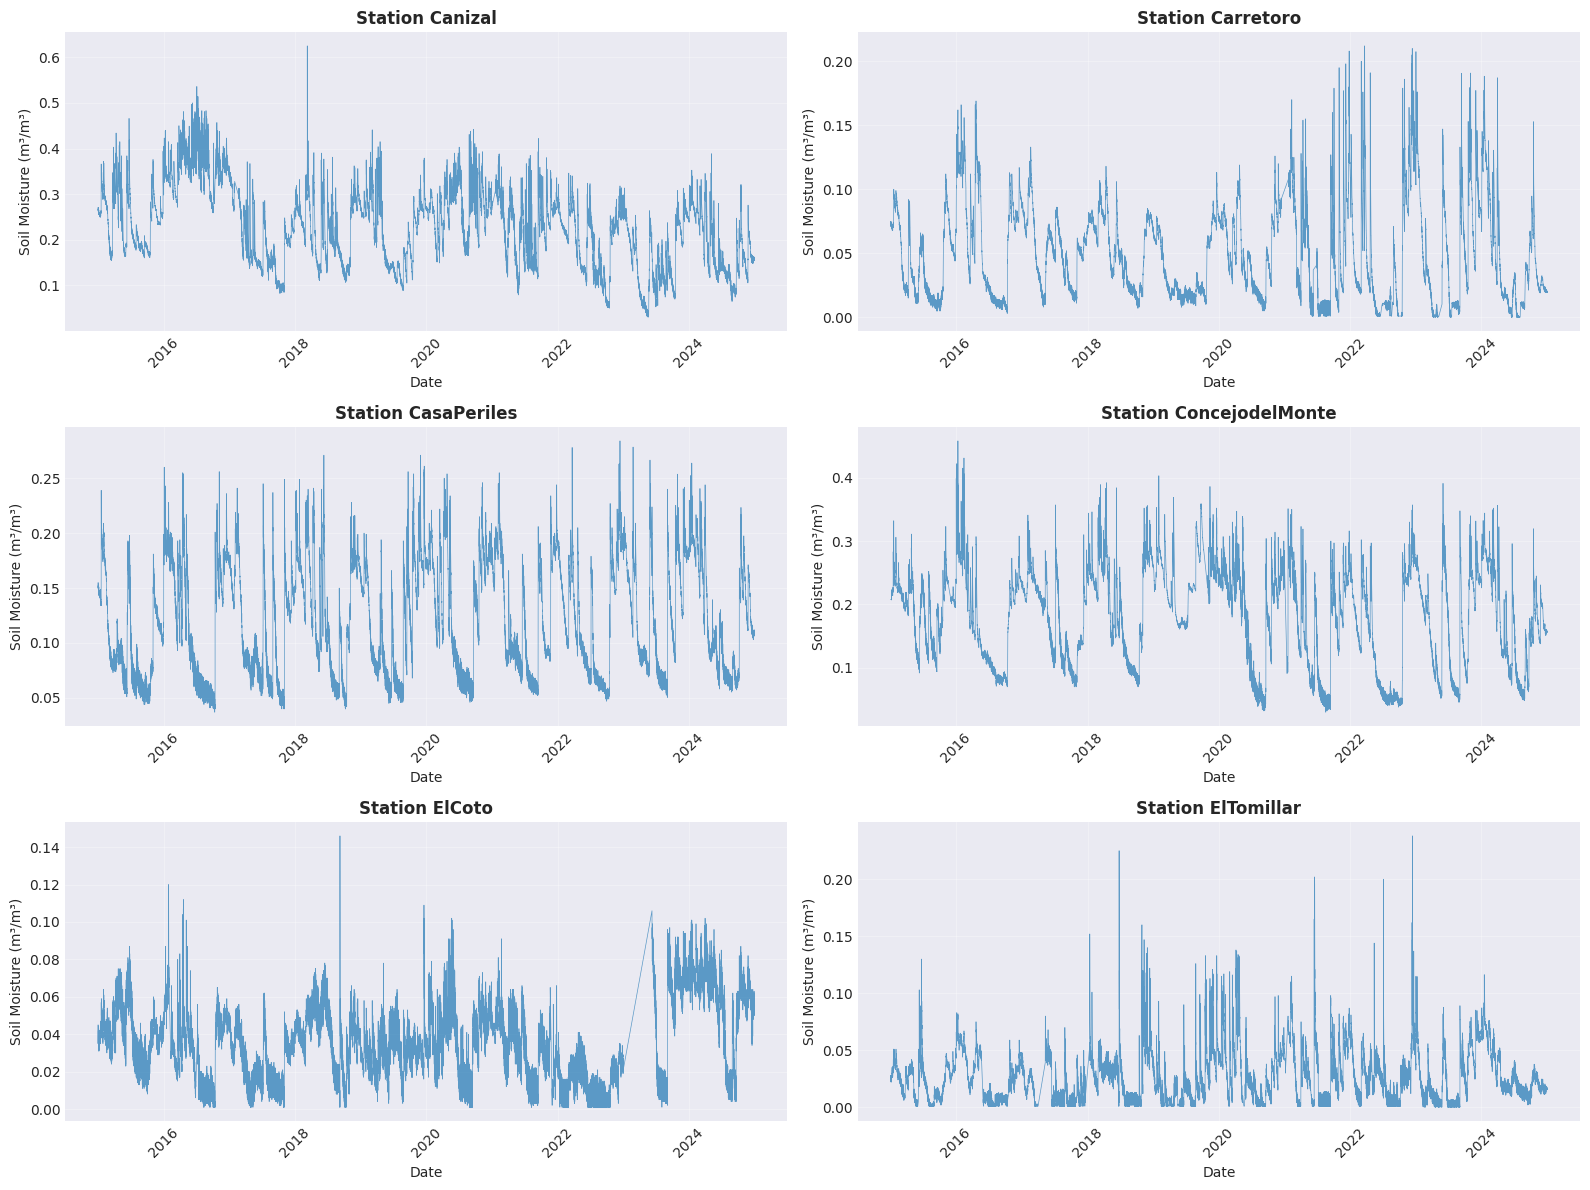

✓ Wykres 2: Serie czasowe wybranych stacji


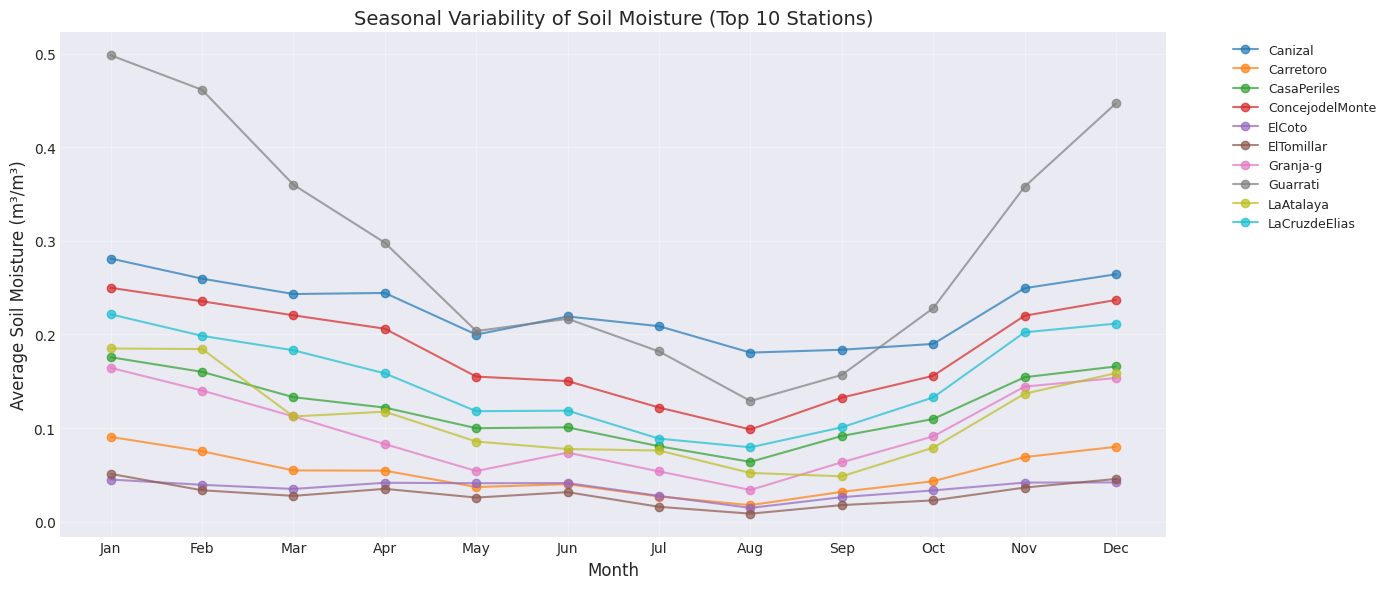

✓ Wykres 3: Sezonowość wilgotności


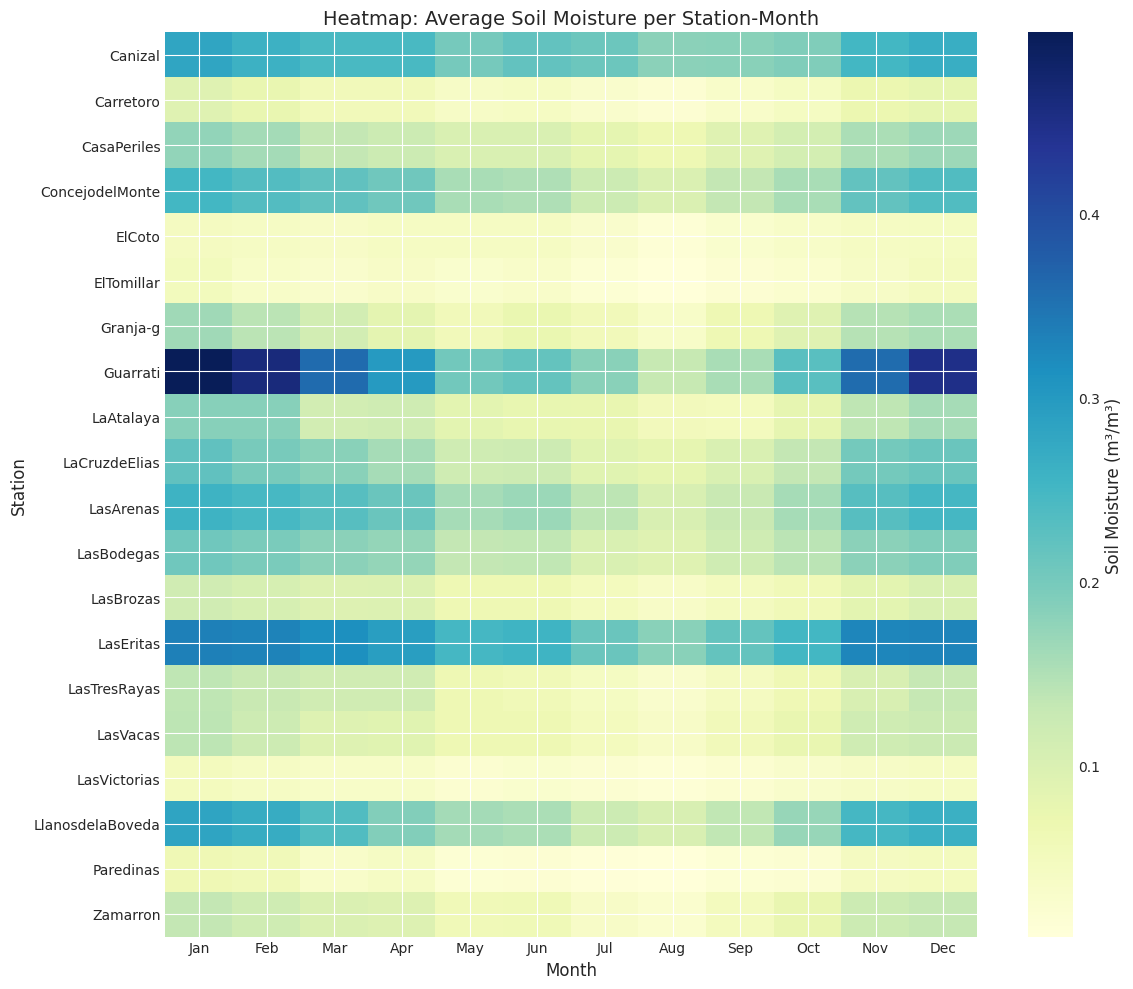

✓ Wykres 4: Heatmap stacja-miesiąc

✅ Wszystkie wykresy zapisane w: /home/jbktn/inzynierka/training_output/plots/


In [14]:
print_section("WIZUALIZACJE DANYCH WILGOTNOŚCI")

# Utwórz katalog na wykresy
plots_dir = os.path.join(config.OUTPUT_DIR, 'plots')
os.makedirs(plots_dir, exist_ok=True)

# ============ WYKRES 1: Rozkład wilgotności (histogram) ============
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Histogram dla wszystkich danych
axes[0].hist(moisture_df['moisture'], bins=50, edgecolor='black', alpha=0.7)
axes[0].axvline(moisture_df['moisture'].mean(), color='red', 
                linestyle='--', linewidth=2, label=f'Mean: {moisture_df["moisture"].mean():.3f}')
axes[0].axvline(moisture_df['moisture'].median(), color='green', 
                linestyle='--', linewidth=2, label=f'Median: {moisture_df["moisture"].median():.3f}')
axes[0].set_xlabel('Soil Moisture (m³/m³)', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Distribution of Soil Moisture (All Stations)', fontsize=14)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Box plot per stacja
stations_to_plot = sorted(moisture_df['station'].unique())[:15]  # Top 15 stacji
data_to_plot = [moisture_df[moisture_df['station']==s]['moisture'].values 
                for s in stations_to_plot]

bp = axes[1].boxplot(data_to_plot, labels=stations_to_plot, patch_artist=True)
for patch in bp['boxes']:
    patch.set_facecolor('lightblue')
axes[1].set_xlabel('Station', fontsize=12)
axes[1].set_ylabel('Soil Moisture (m³/m³)', fontsize=12)
axes[1].set_title('Soil Moisture Distribution per Station (Top 15)', fontsize=14)
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(os.path.join(plots_dir, '01_moisture_distribution.png'), dpi=150, bbox_inches='tight')
plt.show()
print("✓ Wykres 1: Rozkład wilgotności")

# ============ WYKRES 2: Serie czasowe - wybrane stacje ============
fig, axes = plt.subplots(3, 2, figsize=(16, 12))
axes = axes.flatten()

selected_stations = sorted(moisture_df['station'].unique())[:6]

for i, station in enumerate(selected_stations):
    station_data = moisture_df[moisture_df['station'] == station].sort_values('datetime')
    
    axes[i].plot(station_data['datetime'], station_data['moisture'], 
                 linewidth=0.5, alpha=0.7)
    axes[i].set_title(f'Station {station}', fontsize=12, fontweight='bold')
    axes[i].set_xlabel('Date', fontsize=10)
    axes[i].set_ylabel('Soil Moisture (m³/m³)', fontsize=10)
    axes[i].grid(True, alpha=0.3)
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig(os.path.join(plots_dir, '02_timeseries_selected_stations.png'), dpi=150, bbox_inches='tight')
plt.show()
print("✓ Wykres 2: Serie czasowe wybranych stacji")

# ============ WYKRES 3: Sezonowość (średnia per miesiąc) ============
monthly_avg = moisture_df.groupby(['station', 'month'])['moisture'].mean().reset_index()

fig, ax = plt.subplots(figsize=(14, 6))

for station in sorted(moisture_df['station'].unique())[:10]:  # 10 stacji
    station_monthly = monthly_avg[monthly_avg['station'] == station]
    ax.plot(station_monthly['month'], station_monthly['moisture'], 
            marker='o', label=station, alpha=0.7)

ax.set_xlabel('Month', fontsize=12)
ax.set_ylabel('Average Soil Moisture (m³/m³)', fontsize=12)
ax.set_title('Seasonal Variability of Soil Moisture (Top 10 Stations)', fontsize=14)
ax.set_xticks(range(1, 13))
ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                     'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(plots_dir, '03_seasonal_variability.png'), dpi=150, bbox_inches='tight')
plt.show()
print("✓ Wykres 3: Sezonowość wilgotności")

# ============ WYKRES 4: Heatmap - średnia wilgotność per stacja-miesiąc ============
pivot_table = moisture_df.pivot_table(
    values='moisture', 
    index='station', 
    columns='month', 
    aggfunc='mean'
)

fig, ax = plt.subplots(figsize=(12, 10))
im = ax.imshow(pivot_table.values, cmap='YlGnBu', aspect='auto')

# Dodaj colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Soil Moisture (m³/m³)', fontsize=12)

# Etykiety
ax.set_xticks(range(12))
ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                     'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
ax.set_yticks(range(len(pivot_table.index)))
ax.set_yticklabels(pivot_table.index)
ax.set_xlabel('Month', fontsize=12)
ax.set_ylabel('Station', fontsize=12)
ax.set_title('Heatmap: Average Soil Moisture per Station-Month', fontsize=14)

plt.tight_layout()
plt.savefig(os.path.join(plots_dir, '04_heatmap_station_month.png'), dpi=150, bbox_inches='tight')
plt.show()
print("✓ Wykres 4: Heatmap stacja-miesiąc")

print(f"\n✅ Wszystkie wykresy zapisane w: {plots_dir}/")

## 4. Przetwarzanie obrazów satelitarnych
Wyszukiwanie i przetwarzanie obrazów satelitarnych Planet Labs

In [15]:
def find_satellite_images(satellite_dir, pattern='*AnalyticMS_SR*.tif', verbose=True):
    if verbose:
        print_section("WYSZUKIWANIE OBRAZÓW SATELITARNYCH")
    
    if not os.path.exists(satellite_dir):
        raise FileNotFoundError(f"Katalog satelitarny nie istnieje: {satellite_dir}")
    
    image_files = []
    
    # Rekurencyjne wyszukiwanie
    for root, dirs, files in os.walk(satellite_dir):
        for file in files:
            if file.endswith('.tif') and 'AnalyticMS_SR' in file:
                image_files.append(os.path.join(root, file))
    
    if verbose:
        print(f"Znaleziono {len(image_files)} obrazów satelitarnych")
        
        if image_files:
            # Analiza rozmiarów
            total_size = sum(os.path.getsize(f) for f in image_files)
            print(f"Łączny rozmiar: {format_bytes(total_size)}")
            print(f"Średni rozmiar: {format_bytes(total_size/len(image_files))}")
    
    return sorted(image_files)


def extract_image_metadata(image_path, verbose=False):
    filename = os.path.basename(image_path)
    
    # Parsowanie timestamp z nazwy pliku
    # Format: YYYYMMDD_HHMMSS_*_AnalyticMS_SR.tif
    try:
        parts = filename.split('_')
        date_str = parts[0]
        time_str = parts[1]
        timestamp = datetime.strptime(f"{date_str}{time_str}", "%Y%m%d%H%M%S")
    except (IndexError, ValueError):
        # Fallback: użyj czasu modyfikacji pliku
        timestamp = datetime.fromtimestamp(os.path.getmtime(image_path))
        if verbose:
            print(f"⚠️  Nie można sparsować timestamp z nazwy: {filename}")
    
    # Odczytaj geometrię
    try:
        with rasterio.open(image_path) as src:
            bounds = src.bounds
            transform = src.transform
            crs = src.crs
            shape = src.shape
            num_bands = src.count
            dtype = src.dtypes[0]
            nodata = src.nodata
    except Exception as e:
        if verbose:
            print(f"❌ Błąd odczytu {filename}: {e}")
        return None
    
    return {
        'path': image_path,
        'filename': filename,
        'datetime': timestamp,
        'bounds': bounds,
        'transform': transform,
        'crs': str(crs),
        'shape': shape,
        'num_bands': num_bands,
        'dtype': str(dtype),
        'nodata': nodata,
        'file_size': os.path.getsize(image_path)
    }


# Wyszukaj obrazy
with Timer("Wyszukiwanie obrazów satelitarnych"):
    image_files = find_satellite_images(config.SATELLITE_DIR, verbose=True)

# Wyodrębnij metadane
print("\nEkstrakcja metadanych...")
image_metadata = []

for img_path in tqdm(image_files[:100], desc="Przetwarzanie metadanych"):  # Test na 100 pierwszych
    metadata = extract_image_metadata(img_path, verbose=False)
    if metadata is not None:
        image_metadata.append(metadata)

print(f"\n✅ Przetworzono metadane {len(image_metadata)} obrazów")

# Konwersja do DataFrame
metadata_df = pd.DataFrame([
    {
        'filename': m['filename'],
        'datetime': m['datetime'],
        'shape_height': m['shape'][0],
        'shape_width': m['shape'][1],
        'num_bands': m['num_bands'],
        'file_size_mb': m['file_size'] / (1024**2),
        'bounds_left': m['bounds'].left,
        'bounds_right': m['bounds'].right,
        'bounds_bottom': m['bounds'].bottom,
        'bounds_top': m['bounds'].top
    }
    for m in image_metadata
])

print("\nStatystyki obrazów:")
print(metadata_df[['shape_height', 'shape_width', 'num_bands', 'file_size_mb']].describe())

# Zapisz metadane
metadata_path = os.path.join(config.OUTPUT_DIR, 'image_metadata.csv')
metadata_df.to_csv(metadata_path, index=False)
print(f"\n📄 Metadane zapisane: {metadata_path}")

# Zakres czasowy obrazów
print(f"\nZakres czasowy obrazów:")
print(f"   Pierwsze zdjęcie: {metadata_df['datetime'].min()}")
print(f"   Ostatnie zdjęcie: {metadata_df['datetime'].max()}")
print(f"   Rozpiętość: {(metadata_df['datetime'].max() - metadata_df['datetime'].min()).days} dni")

⏱️  Rozpoczęto: Wyszukiwanie obrazów satelitarnych...

  WYSZUKIWANIE OBRAZÓW SATELITARNYCH

Znaleziono 84 obrazów satelitarnych
Łączny rozmiar: 38.53 GB
Średni rozmiar: 469.66 MB
✓ Zakończono: Wyszukiwanie obrazów satelitarnych w 0:00:00.001904

Ekstrakcja metadanych...


Przetwarzanie metadanych: 100%|██████████| 84/84 [00:00<00:00, 1173.58it/s]


✅ Przetworzono metadane 84 obrazów

Statystyki obrazów:
       shape_height   shape_width  num_bands  file_size_mb
count     84.000000     84.000000       84.0     84.000000
mean    5165.178571   9845.619048        8.0    469.664297
std     2494.010469   3517.799144        0.0    349.980105
min      488.000000    314.000000        8.0      0.070339
25%     3397.000000   8262.250000        8.0    111.125785
50%     5427.500000  10998.000000        8.0    450.806775
75%     7447.000000  12457.750000        8.0    794.963585
max     9236.000000  13924.000000        8.0   1062.146338

📄 Metadane zapisane: /home/jbktn/inzynierka/training_output/image_metadata.csv

Zakres czasowy obrazów:
   Pierwsze zdjęcie: 2024-12-01 11:27:19
   Ostatnie zdjęcie: 2024-12-23 11:25:06
   Rozpiętość: 21 dni


## 🗺️ 5. Wycinanie fragmentów obrazów wokół stacji (Patches)

Dla każdej stacji pomiarowej wycinamy kwadratowy fragment obrazu satelitarnego o rozmiarze **64×64 piksele**.

### Proces ekstrakcji patches:

1. **Konwersja współrzędnych**: (lat, lon) → (row, col) w układzie pikseli
2. **Wyznaczenie okna**: Patch 64×64 wyśrodkowany na stacji
3. **Walidacja**: Sprawdzenie czy patch mieści się w granicach obrazu
4. **Odczyt**: Ekstrakcja danych dla wszystkich 8 kanałów
5. **Transformacja**: (bands, height, width) → (height, width, bands)

### Rozmiar patcha w metrach

Przy rozdzielczości 3.7m/piksel:
- **64×64 piksele = ~237m × 237m**
- Pokrywa typowy obszar reprezentatywny dla pomiarów punktowych


  TEST EKSTRAKCJI PATCHES

✅ Testowy obraz: 20241204_112452_73_2523_3B_AnalyticMS_SR_8b_clip_reproject.tif
   Stacji w obrazie: 7
   Testowa stacja: Canizal
   Współrzędne: lat=41.19603, lon=-5.35997

   Stacja: lat=41.19603, lon=-5.35997
   Piksele: row=2455, col=8659
   Obraz: shape=(5540, 13382)
   ✓ Patch shape: (64, 64, 8)
   ✓ Value range: [1007, 3561]

✅ Patch wyekstraktowany pomyślnie!
   Shape: (64, 64, 8)
   Dtype: uint16
   Value range: [1007, 3561]
   Memory: 64.00 KB


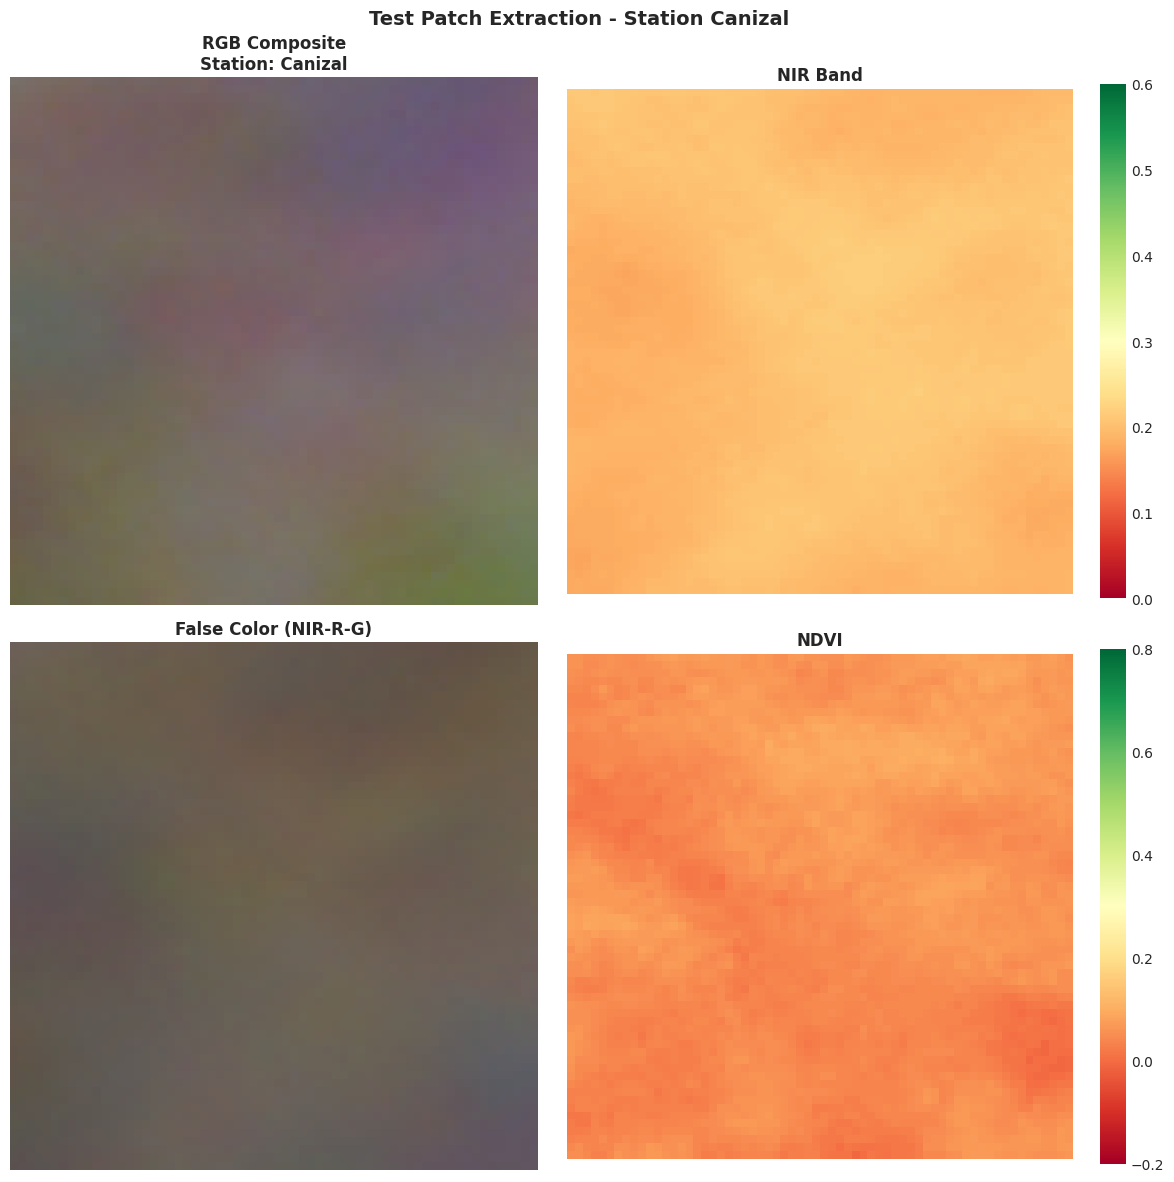


✅ Wizualizacja zapisana: 05_test_patch_visualization.png


In [20]:
"""
TEST EKSTRAKCJI PATCHES - z automatycznym wyborem stacji
"""

print_section("TEST EKSTRAKCJI PATCHES")

if len(image_metadata) > 0 and len(config.STATION_COORDS) > 0:
    # Znajdź pierwszy dobry obraz (z co najmniej 5 stacjami dla lepszego przykładu)
    test_img_meta = None
    test_station = None
    
    for img_meta in image_metadata:
        img_bounds = img_meta['bounds']
        
        # Znajdź stacje w tym obrazie
        stations_in_image = []
        for station, coords in config.STATION_COORDS.items():
            lat = coords['lat']
            lon = coords['lon']
            
            if (img_bounds.left <= lon <= img_bounds.right and 
                img_bounds.bottom <= lat <= img_bounds.top):
                stations_in_image.append((station, coords))
        
        # Użyj obrazu z co najmniej 5 stacjami
        if len(stations_in_image) >= 5:
            test_img_meta = img_meta
            test_station, test_coords = stations_in_image[0]
            break
    
    if test_img_meta is None:
        print("❌ Nie znaleziono odpowiedniego obrazu testowego")
        print("⚠️  Wszystkie obrazy mają mniej niż 5 stacji")
    else:
        print(f"✅ Testowy obraz: {test_img_meta['filename']}")
        print(f"   Stacji w obrazie: {len(stations_in_image)}")
        print(f"   Testowa stacja: {test_station}")
        print(f"   Współrzędne: lat={test_coords['lat']}, lon={test_coords['lon']}\n")
        
        # Wytnij patch
        test_patch = extract_patch_around_station(
            test_img_meta['path'],
            test_coords['lat'],
            test_coords['lon'],
            config.PATCH_SIZE,
            verbose=True
        )
        
        if test_patch is not None:
            print(f"\n✅ Patch wyekstraktowany pomyślnie!")
            print(f"   Shape: {test_patch.shape}")
            print(f"   Dtype: {test_patch.dtype}")
            print(f"   Value range: [{test_patch.min()}, {test_patch.max()}]")
            print(f"   Memory: {test_patch.nbytes / 1024:.2f} KB")
            
            # Wizualizuj patch
            fig, axes = plt.subplots(2, 2, figsize=(12, 12))
            axes = axes.flatten()
            
            # RGB composite
            rgb = test_patch[:, :, [2, 1, 0]] / 10000.0
            rgb = np.clip(rgb * 2.5, 0, 1)
            axes[0].imshow(rgb)
            axes[0].set_title(f'RGB Composite\nStation: {test_station}', fontweight='bold')
            axes[0].axis('off')
            
            # NIR
            nir = test_patch[:, :, 3] / 10000.0
            im1 = axes[1].imshow(nir, cmap='RdYlGn', vmin=0, vmax=0.6)
            axes[1].set_title('NIR Band', fontweight='bold')
            axes[1].axis('off')
            plt.colorbar(im1, ax=axes[1], fraction=0.046)
            
            # False color
            false_color = test_patch[:, :, [3, 2, 1]] / 10000.0
            false_color = np.clip(false_color * 2.0, 0, 1)
            axes[2].imshow(false_color)
            axes[2].set_title('False Color (NIR-R-G)', fontweight='bold')
            axes[2].axis('off')
            
            # NDVI
            red = test_patch[:, :, 2] / 10000.0
            ndvi = (nir - red) / (nir + red + 1e-8)
            im3 = axes[3].imshow(ndvi, cmap='RdYlGn', vmin=-0.2, vmax=0.8)
            axes[3].set_title('NDVI', fontweight='bold')
            axes[3].axis('off')
            plt.colorbar(im3, ax=axes[3], fraction=0.046)
            
            plt.suptitle(f'Test Patch Extraction - Station {test_station}', 
                        fontsize=14, fontweight='bold')
            plt.tight_layout()
            plt.savefig(os.path.join(plots_dir, '05_test_patch_visualization.png'), 
                        dpi=150, bbox_inches='tight')
            plt.show()
            
            print(f"\n✅ Wizualizacja zapisana: 05_test_patch_visualization.png")
            
        else:
            print("\n❌ Nie udało się wyekstraktować patcha")
            print("   Sprawdź verbose logs powyżej")
else:
    print("⚠️  Brak danych do testowania")


In [34]:
"""
ANALIZA: Pokrycie poszczególnych stacji
"""

print_section("POKRYCIE STACJI PRZEZ OBRAZY")

if len(image_metadata) > 0:
    # Zlicz pokrycie dla każdej stacji
    station_coverage = {station: 0 for station in config.STATION_COORDS.keys()}
    
    for img_meta in image_metadata:
        bounds = img_meta['bounds']
        
        for station, coords in config.STATION_COORDS.items():
            if (bounds.left <= coords['lon'] <= bounds.right and
                bounds.bottom <= coords['lat'] <= bounds.top):
                station_coverage[station] += 1
    
    # Sortuj po liczbie obrazów
    sorted_coverage = sorted(station_coverage.items(), key=lambda x: x[1], reverse=True)
    
    print(f"📊 Liczba obrazów pokrywających każdą stację:\n")
    print(f"{'Station':<25} {'Images':>10} {'Coverage':>10}")
    print("="*50)
    
    for station, count in sorted_coverage:
        percentage = count / len(image_metadata) * 100
        print(f"{station:<25} {count:>10} {percentage:>9.1f}%")
    
    # Statystyki
    counts = [c for _, c in sorted_coverage]
    print(f"\n📈 Statystyki pokrycia:")
    print(f"   Min: {min(counts)} obrazów")
    print(f"   Max: {max(counts)} obrazów")
    print(f"   Średnia: {np.mean(counts):.1f} obrazów/stację")
    print(f"   Mediana: {np.median(counts):.0f} obrazów/stację")
    
    # Stacje bez pokrycia
    no_coverage = [s for s, c in sorted_coverage if c == 0]
    if no_coverage:
        print(f"\n⚠️  Stacje BEZ pokrycia ({len(no_coverage)}):")
        for station in no_coverage:
            coords = config.STATION_COORDS[station]
            print(f"   {station}: lat={coords['lat']:.4f}, lon={coords['lon']:.4f}")
else:
    print("⚠️  Brak metadanych obrazów")



  POKRYCIE STACJI PRZEZ OBRAZY

📊 Liczba obrazów pokrywających każdą stację:

Station                       Images   Coverage
Carretoro                         27      44.3%
Las_Eritas                        27      44.3%
La_Atalaya                        26      42.6%
Las_Bodegas                       26      42.6%
Guarrati                          24      39.3%
Canizal                           23      37.7%
Las_Victorias                     23      37.7%
Llanos_de_la_Boveda               23      37.7%
Zamarron                          23      37.7%
Casa_Periles                      22      36.1%
Granja_g                          22      36.1%
Las_Brozas                        22      36.1%
Las_Tres_Rayas                    22      36.1%
El_Coto                           21      34.4%
El_Tomillar                       21      34.4%
Paredinas                         19      31.1%
La_Cruz_de_Elias                  18      29.5%
Las_Vacas                         17      27.9%
Las_Arena

## 🔗 6. Dopasowanie czasowe: Obrazy ↔ Pomiary

Synchronizacja pomiarów wilgotności z obrazami satelitarnymi w oknie czasowym **±3 godziny**.

### Kryteria dopasowania:

1. **Tolerancja czasowa**: |t_image - t_measurement| ≤ 3h
2. **Pokrycie przestrzenne**: Stacja musi być w bounds obrazu
3. **Jakość obrazu**: Patch musi mieć ≥80% ważnych pikseli

### Proces:
For each measurement:
    For each image:
        IF time_difference ≤ 3h AND station_in_bounds:
            CREATE match(image, station, time, moisture)

⏱️  Rozpoczęto: Dopasowanie obrazów do pomiarów...

  DOPASOWANIE OBRAZÓW DO POMIARÓW

Pomiary: 1,578,688
Obrazy: 61
Tolerancja czasowa: ±3h

Pomiary z znanymi współrzędnymi: 390,500


Dopasowywanie: 100%|██████████| 390500/390500 [06:17<00:00, 1034.92it/s, matches=582]



✅ Znaleziono 582 dopasowań obraz-pomiar

Statystyki dopasowań:
   Unikalne obrazy: 41
   Unikalne stacje: 4
   Średnia różnica czasu: 1.50h
   Max różnica czasu: 2.78h

Dopasowań per stacja:
   Carretoro: 162
   Guarrati: 144
   Zamarron: 138
   Canizal: 138
✓ Zakończono: Dopasowanie obrazów do pomiarów w 0:06:17.437154

📄 Dopasowania zapisane: /home/jbktn/inzynierka/training_output/image_measurement_matches.csv


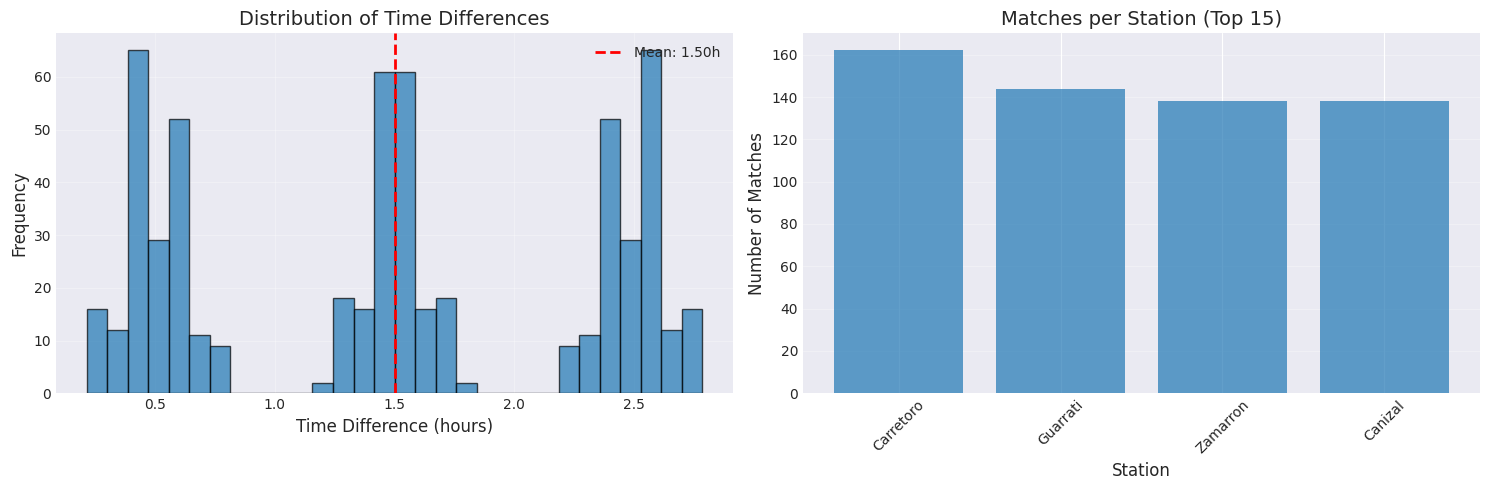

In [23]:
"""
Dopasowanie obrazów satelitarnych do pomiarów wilgotności
"""

def match_images_to_measurements(moisture_df, image_metadata_list, station_coords, 
                                  time_tolerance_hours=3, verbose=True):
    """
    Dopasowuje obrazy satelitarne do pomiarów wilgotności
    
    Args:
        moisture_df (pd.DataFrame): DataFrame z pomiarami
        image_metadata_list (list): Lista słowników z metadanymi obrazów
        station_coords (dict): Słownik ze współrzędnymi stacji
        time_tolerance_hours (float): Tolerancja czasowa w godzinach
        verbose (bool): Czy wyświetlać informacje
    
    Returns:
        list: Lista dopasowań (dict)
    """
    
    if verbose:
        print_section("DOPASOWANIE OBRAZÓW DO POMIARÓW")
        print(f"Pomiary: {len(moisture_df):,}")
        print(f"Obrazy: {len(image_metadata_list):,}")
        print(f"Tolerancja czasowa: ±{time_tolerance_hours}h\n")
    
    matches = []
    
    # Filtruj pomiary dla stacji ze znanymi współrzędnymi
    valid_stations = set(station_coords.keys())
    moisture_filtered = moisture_df[moisture_df['station'].isin(valid_stations)]
    
    if verbose:
        print(f"Pomiary z znanymi współrzędnymi: {len(moisture_filtered):,}")
    
    # Utwórz spatial index obrazów dla szybszego wyszukiwania
    image_bounds_tree = []
    for idx, img_meta in enumerate(image_metadata_list):
        bounds = img_meta['bounds']
        image_bounds_tree.append({
            'idx': idx,
            'bounds': bounds,
            'datetime': img_meta['datetime']
        })
    
    # Progress bar
    pbar = tqdm(
        moisture_filtered.iterrows(), 
        total=len(moisture_filtered),
        desc="Dopasowywanie",
        disable=not verbose
    )
    
    match_count = 0
    
    for idx, row in pbar:
        station = row['station']
        meas_time = row['datetime']
        moisture = row['moisture']
        
        # Współrzędne stacji
        lat = station_coords[station]['lat']
        lon = station_coords[station]['lon']
        
        # Szukaj obrazów w tolerancji czasowej
        for img_tree_item in image_bounds_tree:
            img_time = img_tree_item['datetime']
            time_diff_hours = abs((img_time - meas_time).total_seconds() / 3600)
            
            if time_diff_hours <= time_tolerance_hours:
                # Sprawdź bounds
                bounds = img_tree_item['bounds']
                
                if (bounds.left <= lon <= bounds.right and 
                    bounds.bottom <= lat <= bounds.top):
                    
                    img_meta = image_metadata_list[img_tree_item['idx']]
                    
                    matches.append({
                        'image_path': img_meta['path'],
                        'image_filename': img_meta['filename'],
                        'image_datetime': img_time,
                        'station': station,
                        'lat': lat,
                        'lon': lon,
                        'measurement_datetime': meas_time,
                        'moisture': moisture,
                        'time_diff_hours': time_diff_hours
                    })
                    
                    match_count += 1
        
        # Update progress bar
        pbar.set_postfix({'matches': match_count})
    
    pbar.close()
    
    if verbose:
        print(f"\n✅ Znaleziono {len(matches):,} dopasowań obraz-pomiar")
        
        if matches:
            # Statystyki
            matches_df = pd.DataFrame(matches)
            print(f"\nStatystyki dopasowań:")
            print(f"   Unikalne obrazy: {matches_df['image_filename'].nunique()}")
            print(f"   Unikalne stacje: {matches_df['station'].nunique()}")
            print(f"   Średnia różnica czasu: {matches_df['time_diff_hours'].mean():.2f}h")
            print(f"   Max różnica czasu: {matches_df['time_diff_hours'].max():.2f}h")
            
            # Rozkład per stacja
            print(f"\nDopasowań per stacja:")
            station_counts = matches_df['station'].value_counts().head(10)
            for station, count in station_counts.items():
                print(f"   {station}: {count}")
    
    return matches


# Wykonaj dopasowanie
with Timer("Dopasowanie obrazów do pomiarów"):
    matches = match_images_to_measurements(
        moisture_df,
        image_metadata,
        config.STATION_COORDS,
        config.TIME_TOLERANCE_HOURS,
        verbose=True
    )

# Zapisz dopasowania
if matches:
    matches_df = pd.DataFrame(matches)
    matches_path = os.path.join(config.OUTPUT_DIR, 'image_measurement_matches.csv')
    matches_df.to_csv(matches_path, index=False)
    print(f"\n📄 Dopasowania zapisane: {matches_path}")
    
    # Wizualizacja rozkładu dopasowań
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Histogram różnic czasowych
    axes[0].hist(matches_df['time_diff_hours'], bins=30, edgecolor='black', alpha=0.7)
    axes[0].axvline(matches_df['time_diff_hours'].mean(), color='red', 
                    linestyle='--', linewidth=2, label=f'Mean: {matches_df["time_diff_hours"].mean():.2f}h')
    axes[0].set_xlabel('Time Difference (hours)', fontsize=12)
    axes[0].set_ylabel('Frequency', fontsize=12)
    axes[0].set_title('Distribution of Time Differences', fontsize=14)
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Bar plot dopasowań per stacja
    station_counts = matches_df['station'].value_counts().head(15)
    axes[1].bar(range(len(station_counts)), station_counts.values, alpha=0.7)
    axes[1].set_xticks(range(len(station_counts)))
    axes[1].set_xticklabels(station_counts.index, rotation=45)
    axes[1].set_xlabel('Station', fontsize=12)
    axes[1].set_ylabel('Number of Matches', fontsize=12)
    axes[1].set_title('Matches per Station (Top 15)', fontsize=14)
    axes[1].grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.savefig(os.path.join(plots_dir, '06_matching_statistics.png'), 
                dpi=150, bbox_inches='tight')
    plt.show()
else:
    print("\n⚠️  Brak dopasowań - sprawdź dane i konfigurację")

### Tworzenie datasetu
Generowanie par (patch, moisture)

In [25]:
"""
Tworzenie datasetu treningowego przez ekstrakcję patches
"""

def create_training_dataset(matches, patch_size=64, max_samples=None, verbose=True):
    """
    Tworzy dataset treningowy poprzez wycinanie patches dla każdego dopasowania
    
    Args:
        matches (list): Lista dopasowań
        patch_size (int): Rozmiar patcha
        max_samples (int): Maksymalna liczba próbek (None = wszystkie)
        verbose (bool): Czy wyświetlać informacje
    
    Returns:
        tuple: (X, y, metadata)
            X: np.array shape (n_samples, patch_size, patch_size, num_bands)
            y: np.array shape (n_samples,)
            metadata: list of dicts
    """
    
    if verbose:
        print_section("TWORZENIE DATASETU TRENINGOWEGO")
    
    if max_samples is not None:
        matches = matches[:max_samples]
        if verbose:
            print(f"Ograniczono do {max_samples} próbek\n")
    
    X = []
    y = []
    metadata = []
    
    failed_count = 0
    cache = {}  # Cache dla otwartych obrazów
    
    pbar = tqdm(matches, desc="Ekstrakcja patches", disable=not verbose)
    
    for match in pbar:
        try:
            image_path = match['image_path']
            
            # Wytnij patch
            patch = extract_patch_around_station(
                image_path,
                match['lat'],
                match['lon'],
                patch_size,
                verbose=False
            )
            
            if patch is not None:
                # Walidacja patcha
                if np.isnan(patch).any() or np.isinf(patch).any():
                    failed_count += 1
                    continue
                
                X.append(patch)
                y.append(match['moisture'])
                metadata.append({
                    'station': match['station'],
                    'measurement_datetime': match['measurement_datetime'],
                    'image_datetime': match['image_datetime'],
                    'image_filename': match['image_filename'],
                    'time_diff_hours': match['time_diff_hours']
                })
            else:
                failed_count += 1
        
        except Exception as e:
            if verbose:
                pbar.write(f"Błąd: {e}")
            failed_count += 1
            continue
        
        # Update progress
        pbar.set_postfix({
            'success': len(X),
            'failed': failed_count,
            'success_rate': f'{len(X)/(len(X)+failed_count)*100:.1f}%'
        })
    
    pbar.close()
    
    # Konwersja do numpy arrays
    X = np.array(X, dtype=np.float32)
    y = np.array(y, dtype=np.float32)
    
    if verbose:
        print(f"\n✅ Dataset utworzony:")
        print(f"   Próbki (X): {X.shape}")
        print(f"   Etykiety (y): {y.shape}")
        print(f"   Pamięć X: {X.nbytes / (1024**2):.2f} MB")
        print(f"   Udane ekstrakcje: {len(X):,}")
        print(f"   Nieudane ekstrakcje: {failed_count:,}")
        print(f"   Success rate: {len(X)/(len(X)+failed_count)*100:.1f}%")
    
    return X, y, metadata


# Utwórz dataset
with Timer("Tworzenie datasetu"):
    X, y, dataset_metadata = create_training_dataset(
        matches,
        config.PATCH_SIZE,
        max_samples=None,  # Wszystkie dostępne
        verbose=True
    )

# Zapisz metadane datasetu
metadata_path = os.path.join(config.OUTPUT_DIR, 'dataset_metadata.json')
with open(metadata_path, 'w') as f:
    json.dump(
        [{**m, 
          'measurement_datetime': m['measurement_datetime'].isoformat(),
          'image_datetime': m['image_datetime'].isoformat()}
         for m in dataset_metadata],
        f, 
        indent=2
    )

print(f"\n📄 Metadane datasetu zapisane: {metadata_path}")

# Podstawowe statystyki
print(f"\nStatystyki datasetu:")
print(f"   X dtype: {X.dtype}")
print(f"   X range: [{X.min():.0f}, {X.max():.0f}]")
print(f"   y range: [{y.min():.4f}, {y.max():.4f}]")
print(f"   y mean: {y.mean():.4f} ± {y.std():.4f}")

⏱️  Rozpoczęto: Tworzenie datasetu...

  TWORZENIE DATASETU TRENINGOWEGO



Ekstrakcja patches: 100%|██████████| 582/582 [00:06<00:00, 90.29it/s, success=348, failed=234, success_rate=59.8%] 



✅ Dataset utworzony:
   Próbki (X): (348, 64, 64, 8)
   Etykiety (y): (348,)
   Pamięć X: 43.50 MB
   Udane ekstrakcje: 348
   Nieudane ekstrakcje: 234
   Success rate: 59.8%
✓ Zakończono: Tworzenie datasetu w 0:00:06.462112

📄 Metadane datasetu zapisane: /home/jbktn/inzynierka/training_output/dataset_metadata.json

Statystyki datasetu:
   X dtype: float32
   X range: [1, 7713]
   y range: [0.0194, 0.4023]
   y mean: 0.1540 ± 0.1164


### Podział danych i normalizacja


  PODZIAŁ DATASETU I NORMALIZACJA

1️⃣  Podział na zbiory train/val/test:
   Train: 243 samples (69.8%)
   Val:   52 samples (14.9%)
   Test:  53 samples (15.2%)

2️⃣  Normalizacja:
   Planet Labs SR: 0-10000 → 0-1

   Po normalizacji:
   X_train: [0.0001, 0.7713]
   X_val:   [0.0001, 0.7713]
   X_test:  [0.0005, 0.4475]

3️⃣  Statystyki per kanał spektralny:
    Band   Mean    Std    Min    Max
    Blue 0.0445 0.0599 0.0001 0.6774
   Green 0.0540 0.0577 0.0001 0.6610
     Red 0.0796 0.0596 0.0001 0.7051
     NIR 0.0974 0.0569 0.0001 0.6870
RedEdge1 0.1177 0.0576 0.0001 0.6948
RedEdge2 0.1266 0.0615 0.0001 0.7078
RedEdge3 0.1604 0.0572 0.0085 0.7205
RedEdge4 0.2444 0.0651 0.0544 0.7713


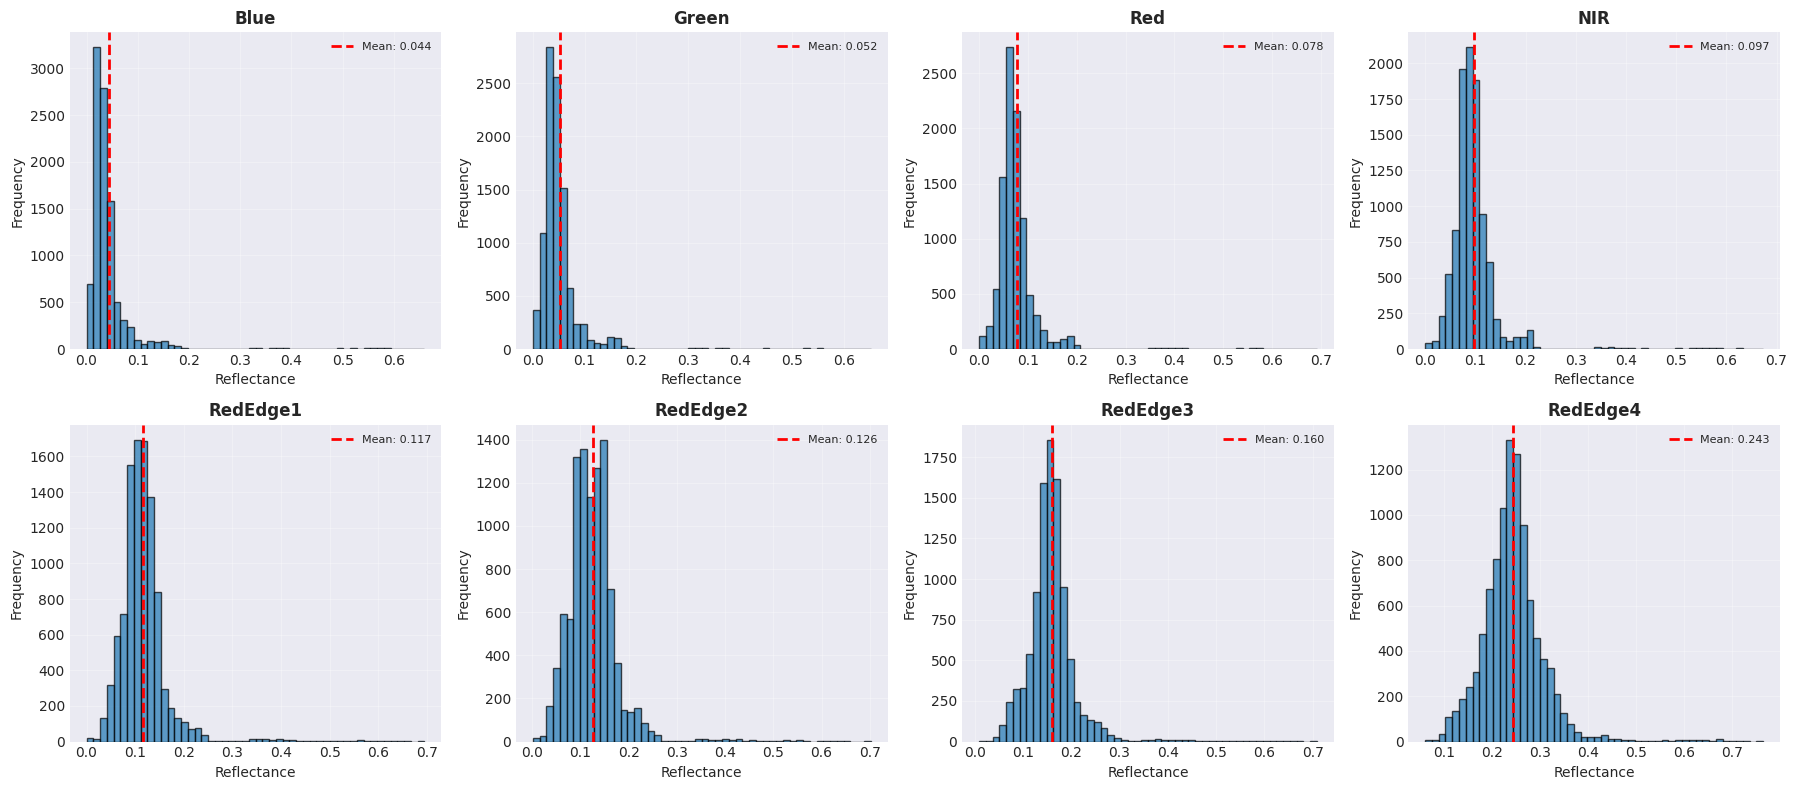


✅ Dataset przygotowany i znormalizowany!


In [26]:
print_section("PODZIAŁ DATASETU I NORMALIZACJA")

# ==================== 1. PODZIAŁ DANYCH ====================
print("1️⃣  Podział na zbiory train/val/test:")

# Split 1: Train vs (Val + Test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, 
    test_size=(config.VALIDATION_SPLIT + config.TEST_SPLIT),
    random_state=42,
    shuffle=True
)

# Split 2: Val vs Test
val_ratio = config.VALIDATION_SPLIT / (config.VALIDATION_SPLIT + config.TEST_SPLIT)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=(1 - val_ratio),
    random_state=42,
    shuffle=True
)

print(f"   Train: {X_train.shape[0]:,} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"   Val:   {X_val.shape[0]:,} samples ({X_val.shape[0]/len(X)*100:.1f}%)")
print(f"   Test:  {X_test.shape[0]:,} samples ({X_test.shape[0]/len(X)*100:.1f}%)")

# ==================== 2. NORMALIZACJA ====================
print(f"\n2️⃣  Normalizacja:")
print(f"   Planet Labs SR: 0-10000 → 0-1")

def normalize_patches(X_train, X_val, X_test):
    """
    Normalizuje patches Planet Labs Surface Reflectance
    Zakres: 0-10000 → 0-1
    """
    X_train_norm = np.clip(X_train / 10000.0, 0, 1).astype(np.float32)
    X_val_norm = np.clip(X_val / 10000.0, 0, 1).astype(np.float32)
    X_test_norm = np.clip(X_test / 10000.0, 0, 1).astype(np.float32)
    
    return X_train_norm, X_val_norm, X_test_norm

X_train_norm, X_val_norm, X_test_norm = normalize_patches(X_train, X_val, X_test)

print(f"\n   Po normalizacji:")
print(f"   X_train: [{X_train_norm.min():.4f}, {X_train_norm.max():.4f}]")
print(f"   X_val:   [{X_val_norm.min():.4f}, {X_val_norm.max():.4f}]")
print(f"   X_test:  [{X_test_norm.min():.4f}, {X_test_norm.max():.4f}]")

# ==================== 3. STATYSTYKI PER KANAŁ ====================
print(f"\n3️⃣  Statystyki per kanał spektralny:")

band_names = ['Blue', 'Green', 'Red', 'NIR', 'RedEdge1', 'RedEdge2', 'RedEdge3', 'RedEdge4']

stats_table = []
for i, name in enumerate(band_names):
    if i < X_train_norm.shape[-1]:
        band_data = X_train_norm[:, :, :, i]
        stats_table.append({
            'Band': name,
            'Mean': f"{band_data.mean():.4f}",
            'Std': f"{band_data.std():.4f}",
            'Min': f"{band_data.min():.4f}",
            'Max': f"{band_data.max():.4f}"
        })

stats_df = pd.DataFrame(stats_table)
print(stats_df.to_string(index=False))

# ==================== 4. WIZUALIZACJA ROZKŁADÓW ====================
fig, axes = plt.subplots(2, 4, figsize=(18, 8))
axes = axes.flatten()

for i, name in enumerate(band_names):
    if i < X_train_norm.shape[-1]:
        # Losowo wybierz 1000 pikseli z każdego kanału
        sample_pixels = X_train_norm[:, :, :, i].flatten()
        sample_pixels = np.random.choice(sample_pixels, size=min(10000, len(sample_pixels)), replace=False)
        
        axes[i].hist(sample_pixels, bins=50, edgecolor='black', alpha=0.7)
        axes[i].axvline(sample_pixels.mean(), color='red', linestyle='--', 
                       linewidth=2, label=f'Mean: {sample_pixels.mean():.3f}')
        axes[i].set_title(f'{name}', fontsize=12, fontweight='bold')
        axes[i].set_xlabel('Reflectance', fontsize=10)
        axes[i].set_ylabel('Frequency', fontsize=10)
        axes[i].legend(fontsize=8)
        axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(plots_dir, '07_band_distributions.png'), dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✅ Dataset przygotowany i znormalizowany!")

# Zapisz znormalizowane dane (opcjonalnie - zajmuje dużo miejsca)
save_normalized = False  # Zmień na True jeśli chcesz zapisać

if save_normalized:
    print("\nZapisywanie znormalizowanych danych...")
    np.savez_compressed(
        os.path.join(config.OUTPUT_DIR, 'dataset_normalized.npz'),
        X_train=X_train_norm,
        X_val=X_val_norm,
        X_test=X_test_norm,
        y_train=y_train,
        y_val=y_val,
        y_test=y_test
    )
    print(f"✓ Zapisano: dataset_normalized.npz")

### Wyświetlanie przykładowych patches


  WIZUALIZACJA PRZYKŁADOWYCH PRÓBEK



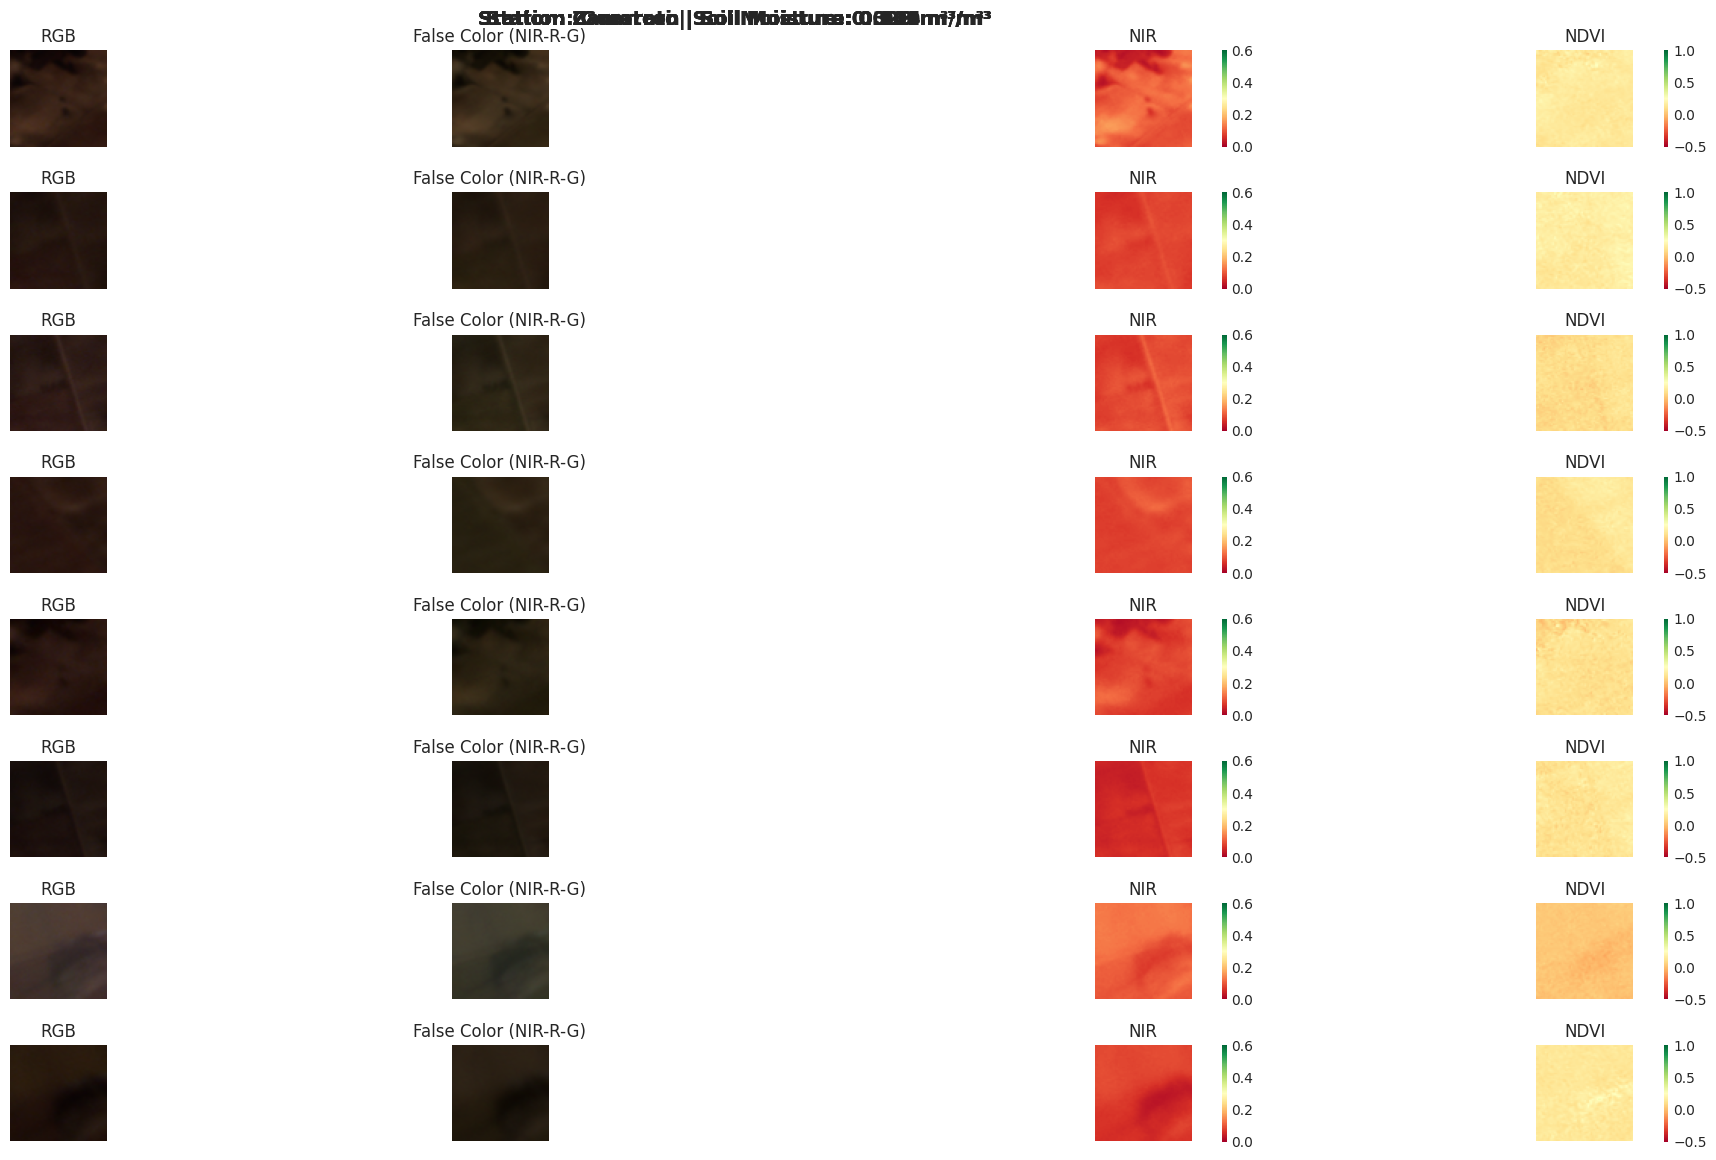

✓ Wizualizacja zapisana: 08_sample_patches_detailed.png


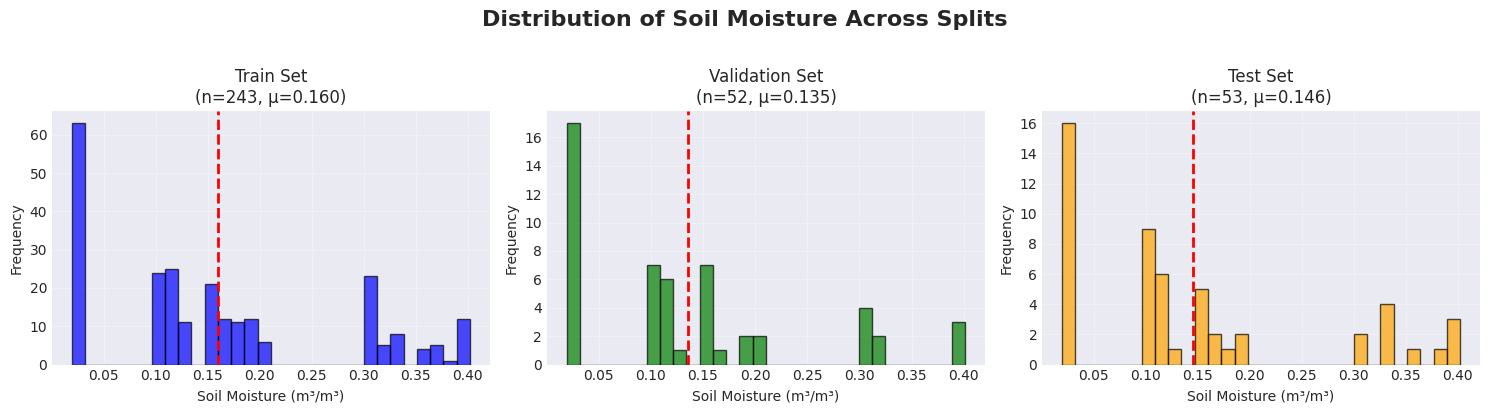

✓ Wizualizacja rozkładów zapisana: 09_moisture_distribution_splits.png

✅ Wszystkie wizualizacje wygenerowane pomyślnie!


In [27]:
print_section("WIZUALIZACJA PRZYKŁADOWYCH PRÓBEK")

# ==================== FUNKCJA POMOCNICZA ====================
def visualize_sample(patch, moisture, station, ax_list, title_suffix=""):
    """
    Wizualizuje jeden sample w 4 reprezentacjach
    
    Args:
        patch: Znormalizowany patch (H, W, 8)
        moisture: Wartość wilgotności
        station: Nazwa stacji
        ax_list: Lista 4 axes
        title_suffix: Dodatkowy suffix do tytułu
    """
    
    # 1. True Color RGB (R, G, B)
    rgb = patch[:, :, [2, 1, 0]]
    rgb = np.clip(rgb * 2.5, 0, 1)  # Zwiększ kontrast
    ax_list[0].imshow(rgb)
    ax_list[0].set_title(f'RGB{title_suffix}')
    ax_list[0].axis('off')
    
    # 2. False Color (NIR, R, G)
    false_color = patch[:, :, [3, 2, 1]]
    false_color = np.clip(false_color * 2.0, 0, 1)
    ax_list[1].imshow(false_color)
    ax_list[1].set_title(f'False Color (NIR-R-G)')
    ax_list[1].axis('off')
    
    # 3. NIR Band
    nir = patch[:, :, 3]
    im3 = ax_list[2].imshow(nir, cmap='RdYlGn', vmin=0, vmax=0.6)
    ax_list[2].set_title(f'NIR')
    ax_list[2].axis('off')
    plt.colorbar(im3, ax=ax_list[2], fraction=0.046)
    
    # 4. NDVI
    red = patch[:, :, 2]
    ndvi = (nir - red) / (nir + red + 1e-8)
    im4 = ax_list[3].imshow(ndvi, cmap='RdYlGn', vmin=-0.5, vmax=1.0)
    ax_list[3].set_title(f'NDVI')
    ax_list[3].axis('off')
    plt.colorbar(im4, ax=ax_list[3], fraction=0.046)
    
    # Wspólny tytuł
    fig.text(0.5, 0.95, 
             f'Station: {station} | Soil Moisture: {moisture:.3f} m³/m³',
             ha='center', fontsize=14, fontweight='bold')


# ==================== WIZUALIZACJA 8 PRÓBEK ====================
num_samples = 8
indices = np.random.choice(len(X_train_norm), size=num_samples, replace=False)

fig = plt.figure(figsize=(20, 12))

for idx, sample_idx in enumerate(indices):
    patch = X_train_norm[sample_idx]
    moisture = y_train[sample_idx]
    
    # Znajdź metadane dla tego sampla
    if idx < len(dataset_metadata):
        station = dataset_metadata[sample_idx]['station']
    else:
        station = "Unknown"
    
    # Utwórz 4 subploty dla każdego sampla
    axes = [
        fig.add_subplot(num_samples, 4, idx*4 + 1),
        fig.add_subplot(num_samples, 4, idx*4 + 2),
        fig.add_subplot(num_samples, 4, idx*4 + 3),
        fig.add_subplot(num_samples, 4, idx*4 + 4)
    ]
    
    visualize_sample(patch, moisture, station, axes)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig(os.path.join(plots_dir, '08_sample_patches_detailed.png'), 
            dpi=150, bbox_inches='tight')
plt.show()

print("✓ Wizualizacja zapisana: 08_sample_patches_detailed.png")

# ==================== ROZKŁAD WILGOTNOŚCI W ZBIORACH ====================
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].hist(y_train, bins=30, edgecolor='black', alpha=0.7, color='blue')
axes[0].axvline(y_train.mean(), color='red', linestyle='--', linewidth=2)
axes[0].set_title(f'Train Set\n(n={len(y_train):,}, μ={y_train.mean():.3f})')
axes[0].set_xlabel('Soil Moisture (m³/m³)')
axes[0].set_ylabel('Frequency')
axes[0].grid(True, alpha=0.3)

axes[1].hist(y_val, bins=30, edgecolor='black', alpha=0.7, color='green')
axes[1].axvline(y_val.mean(), color='red', linestyle='--', linewidth=2)
axes[1].set_title(f'Validation Set\n(n={len(y_val):,}, μ={y_val.mean():.3f})')
axes[1].set_xlabel('Soil Moisture (m³/m³)')
axes[1].set_ylabel('Frequency')
axes[1].grid(True, alpha=0.3)

axes[2].hist(y_test, bins=30, edgecolor='black', alpha=0.7, color='orange')
axes[2].axvline(y_test.mean(), color='red', linestyle='--', linewidth=2)
axes[2].set_title(f'Test Set\n(n={len(y_test):,}, μ={y_test.mean():.3f})')
axes[2].set_xlabel('Soil Moisture (m³/m³)')
axes[2].set_ylabel('Frequency')
axes[2].grid(True, alpha=0.3)

plt.suptitle('Distribution of Soil Moisture Across Splits', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(os.path.join(plots_dir, '09_moisture_distribution_splits.png'), 
            dpi=150, bbox_inches='tight')
plt.show()

print("✓ Wizualizacja rozkładów zapisana: 09_moisture_distribution_splits.png")

print("\n✅ Wszystkie wizualizacje wygenerowane pomyślnie!")

## Budowa modelu hybrydowego: CNN (feature extractor) + XGBoost (regressor)

In [37]:
# ==================== 1. CNN BASE (Feature Extractor) ====================

def build_cnn_feature_extractor(input_shape=(64, 64, 8), feature_dim=128):
    """
    CNN do ekstrakcji cech bez warstwy regresji
    
    Args:
        input_shape: kształt wejścia
        feature_dim: wymiar wyjściowych cech (128, 256, 512)
    
    Returns:
        keras.Model bez warstwy output
    """
    
    model = keras.Sequential(name="CNN_FeatureExtractor")
    
    # Input
    model.add(layers.Input(shape=input_shape, name='input'))
    
    # Block 1
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', name='conv1'))
    model.add(layers.BatchNormalization(name='bn1'))
    
    # Block 2
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='conv2'))
    model.add(layers.BatchNormalization(name='bn2'))
    model.add(layers.MaxPooling2D((2, 2), name='pool1'))
    model.add(layers.Dropout(0.25, name='dropout1'))
    
    # Block 3
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='conv3'))
    model.add(layers.BatchNormalization(name='bn3'))
    model.add(layers.MaxPooling2D((2, 2), name='pool2'))
    model.add(layers.Dropout(0.25, name='dropout2'))
    
    # Block 4
    model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='conv4'))
    model.add(layers.BatchNormalization(name='bn4'))
    model.add(layers.MaxPooling2D((2, 2), name='pool3'))
    model.add(layers.Dropout(0.5, name='dropout3'))
    
    # Fully Connected Feature Layer
    model.add(layers.Flatten(name='flatten'))
    model.add(layers.Dense(feature_dim, activation='relu', name='features'))
    model.add(layers.BatchNormalization(name='bn_features'))
    model.add(layers.Dropout(0.3, name='dropout_features'))
    
    # BRAK warstwy output - to zrobi XGBoost!
    
    return model

# Zbuduj CNN feature extractor
input_shape = (config.PATCH_SIZE, config.PATCH_SIZE, config.NUM_BANDS)
cnn_base = build_cnn_feature_extractor(input_shape, feature_dim=128)

print("\n" + "="*70)
print("CNN FEATURE EXTRACTOR")
print("="*70)
cnn_base.summary()

# Liczba parametrów
total_params = cnn_base.count_params()
print(f"\nParametry CNN: {total_params:,}")

# ==================== 2. WSTĘPNY MODEL CNN (dla pre-treningu) ====================

# Dodaj tymczasową warstwę output do wstępnego treningu
cnn_pretrain = keras.Sequential([
    cnn_base,
    layers.Dense(1, activation='sigmoid', name='pretrain_output')
], name="CNN_Pretrain")

print("\n" + "="*70)
print("MODEL CNN DO PRE-TRENINGU")
print("="*70)
print("Ten model zostanie użyty do wstępnego nauczenia CNN,")
print("a następnie ostatnia warstwa zostanie usunięta i zastąpiona XGBoost")
print("="*70)



CNN FEATURE EXTRACTOR


Model: "CNN_FeatureExtractor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1 (Conv2D)                  │ (None, 64, 64, 32)     │         2,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn1 (BatchNormalization)        │ (None, 64, 64, 32)     │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn2 (BatchNormalization)        │ (None, 64, 64, 64)     │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout1 (Dropout)              │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3 (Conv2D)                  │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn3 (BatchNormalization)        │ (None, 32, 32, 128)    │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout2 (Dropout)              │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv4 (Conv2D)                  │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn4 (BatchNormalization)        │ (None, 16, 16, 256)    │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool3 (MaxPooling2D)            │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout3 (Dropout)              │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ features (Dense)                │ (None, 128)            │     2,097,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_features                     │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_features (Dropout)      │ (None, 128)            │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,489,568 (9.50 MB)

 Trainable params: 2,488,352 (9.49 MB)

 Non-trainable params: 1,216 (4.75 KB)


Parametry CNN: 2,489,568

MODEL CNN DO PRE-TRENINGU
Ten model zostanie użyty do wstępnego nauczenia CNN,
a następnie ostatnia warstwa zostanie usunięta i zastąpiona XGBoost


### Wstępne trenowanie CNN jako feature extractor

✓ Kompilacja zakończona

🔄 Rozpoczynam wstępne trenowanie CNN (max 30 epok)...
Cel: Nauczyć CNN ekstrakcji użytecznych cech przestrzennych

⏱️  Rozpoczęto: Pre-trenowanie CNN...
Epoch 1/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 384ms/step - loss: 0.1652 - mae: 0.3032 - rmse: 0.4065 - val_loss: 0.0179 - val_mae: 0.1096 - val_rmse: 0.1338 - learning_rate: 0.0010
Epoch 2/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 341ms/step - loss: 0.1146 - mae: 0.2363 - rmse: 0.3385 - val_loss: 0.0287 - val_mae: 0.1194 - val_rmse: 0.1694 - learning_rate: 0.0010
Epoch 3/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 339ms/step - loss: 0.1025 - mae: 0.2153 - rmse: 0.3201 - val_loss: 0.0397 - val_mae: 0.1427 - val_rmse: 0.1993 - learning_rate: 0.0010
Epoch 4/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 344ms/step - loss: 0.0784 - mae: 0.1749 - rmse: 0.2800 - val_loss: 0.0361 - val_mae: 0.1411 - val_rmse: 0.1901 - learning_rate: 0.0010
Epoch 5/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 341ms/step - loss: 0.0732 - mae: 0.1652 - rmse: 0.2706 - val_loss: 0.0282 - val_mae: 0.

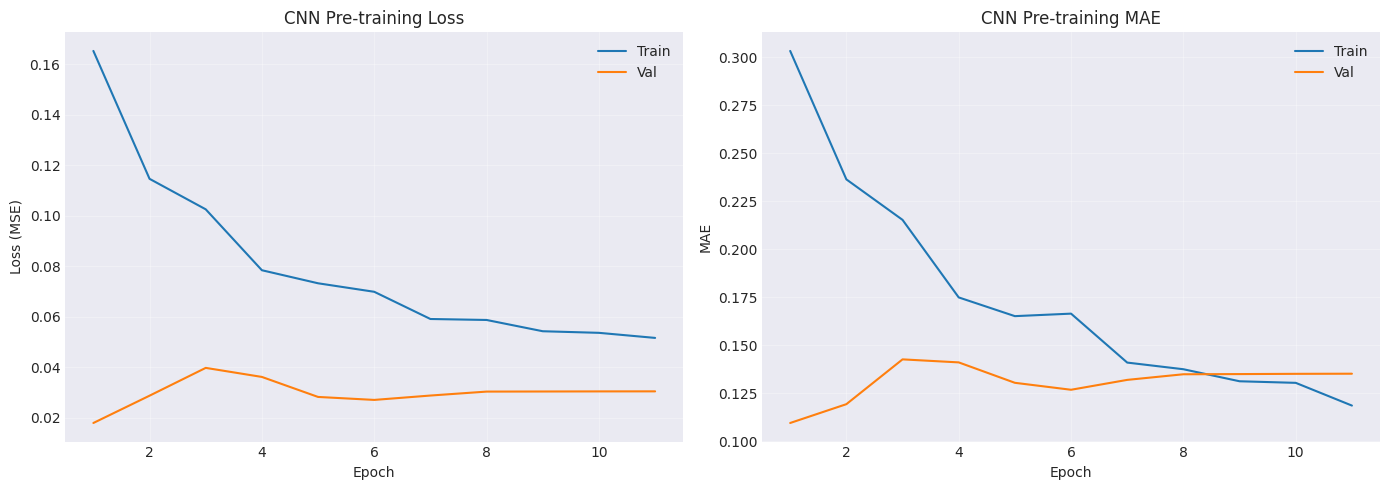

✓ Wykres pre-treningu zapisany


In [38]:
# Kompilacja
cnn_pretrain.compile(
    optimizer=keras.optimizers.Adam(learning_rate=config.LEARNING_RATE),
    loss='mse',
    metrics=['mae', tf.keras.metrics.RootMeanSquaredError(name='rmse')]
)

print("✓ Kompilacja zakończona")

# Callbacks (tylko podstawowe dla pre-treningu)
pretrain_callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-6,
        verbose=1
    )
]

print("\n🔄 Rozpoczynam wstępne trenowanie CNN (max 30 epok)...")
print("Cel: Nauczyć CNN ekstrakcji użytecznych cech przestrzennych\n")

# Pre-trenowanie (mniej epok niż normalnie)
pretrain_epochs = min(30, config.EPOCHS // 2)

with Timer("Pre-trenowanie CNN"):
    pretrain_history = cnn_pretrain.fit(
        X_train_norm, y_train,
        batch_size=config.BATCH_SIZE,
        epochs=pretrain_epochs,
        validation_data=(X_val_norm, y_val),
        callbacks=pretrain_callbacks,
        verbose=1
    )

print(f"\n✅ Pre-trenowanie zakończone!")
print(f"   Epoki: {len(pretrain_history.history['loss'])}")
print(f"   Final train loss: {pretrain_history.history['loss'][-1]:.4f}")
print(f"   Final val loss: {pretrain_history.history['val_loss'][-1]:.4f}")

# Wizualizacja pre-treningu
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

epochs_range = range(1, len(pretrain_history.history['loss']) + 1)

axes[0].plot(epochs_range, pretrain_history.history['loss'], label='Train')
axes[0].plot(epochs_range, pretrain_history.history['val_loss'], label='Val')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss (MSE)')
axes[0].set_title('CNN Pre-training Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(epochs_range, pretrain_history.history['mae'], label='Train')
axes[1].plot(epochs_range, pretrain_history.history['val_mae'], label='Val')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('MAE')
axes[1].set_title('CNN Pre-training MAE')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(plots_dir, '10a_cnn_pretraining.png'), dpi=150, bbox_inches='tight')
plt.show()

print("✓ Wykres pre-treningu zapisany")


### Ekstrakcja cech używając wytrenowanego CNN

1️⃣  Ekstrakcja cech ze zbiorów danych...
⏱️  Rozpoczęto: Ekstrakcja cech...

Train set...
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step
Validation set...
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Test set...
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
✓ Zakończono: Ekstrakcja cech w 0:00:00.952592

✅ Ekstrakcja zakończona!
   Train features: (243, 128)
   Val features: (52, 128)
   Test features: (53, 128)

📊 Statystyki cech:
   Mean: -0.0153
   Std: 0.2906
   Min: -0.4139
   Max: 1.0901


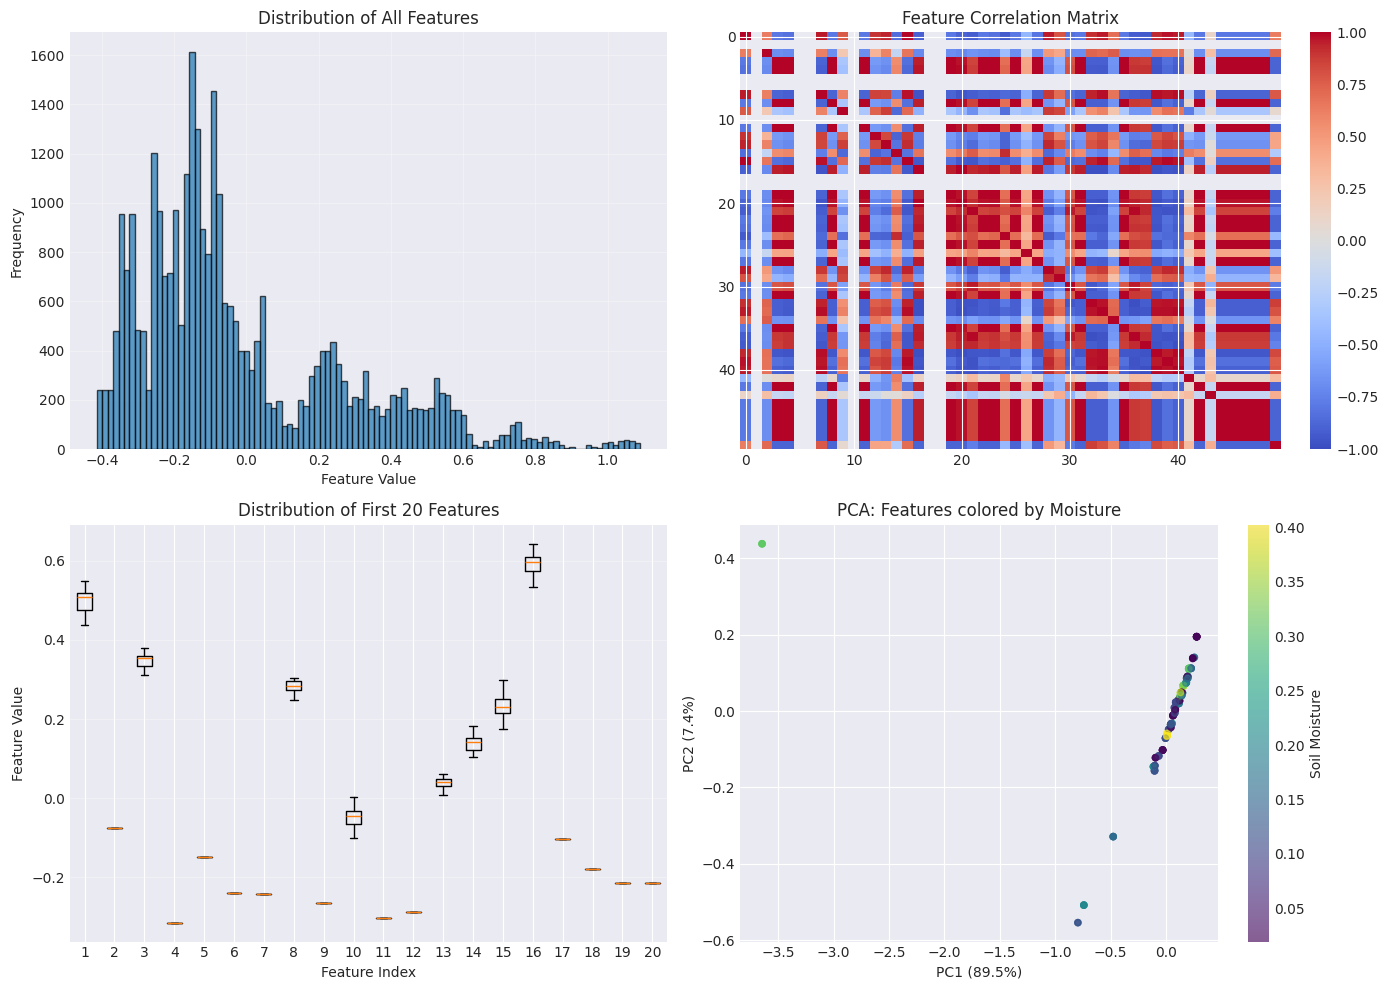


✓ Analiza cech zapisana


In [39]:
print("1️⃣  Ekstrakcja cech ze zbiorów danych...")

# Użyj cnn_base (bez ostatniej warstwy) do ekstrakcji cech
with Timer("Ekstrakcja cech"):
    print("\nTrain set...")
    features_train = cnn_base.predict(X_train_norm, batch_size=config.BATCH_SIZE, verbose=1)
    
    print("Validation set...")
    features_val = cnn_base.predict(X_val_norm, batch_size=config.BATCH_SIZE, verbose=1)
    
    print("Test set...")
    features_test = cnn_base.predict(X_test_norm, batch_size=config.BATCH_SIZE, verbose=1)

print(f"\n✅ Ekstrakcja zakończona!")
print(f"   Train features: {features_train.shape}")
print(f"   Val features: {features_val.shape}")
print(f"   Test features: {features_test.shape}")

# Statystyki cech
print(f"\n📊 Statystyki cech:")
print(f"   Mean: {features_train.mean():.4f}")
print(f"   Std: {features_train.std():.4f}")
print(f"   Min: {features_train.min():.4f}")
print(f"   Max: {features_train.max():.4f}")

# Wizualizacja rozkładu cech
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Histogram wszystkich cech
axes[0, 0].hist(features_train.flatten(), bins=100, alpha=0.7, edgecolor='black')
axes[0, 0].set_xlabel('Feature Value')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Distribution of All Features')
axes[0, 0].grid(True, alpha=0.3)

# Heatmap korelacji (pierwsze 50 cech)
if features_train.shape[1] <= 50:
    corr = np.corrcoef(features_train.T)
else:
    corr = np.corrcoef(features_train[:, :50].T)

im = axes[0, 1].imshow(corr, cmap='coolwarm', aspect='auto', vmin=-1, vmax=1)
axes[0, 1].set_title('Feature Correlation Matrix')
plt.colorbar(im, ax=axes[0, 1], fraction=0.046)

# Box plot wybranych cech
n_features_to_show = min(20, features_train.shape[1])
axes[1, 0].boxplot([features_train[:, i] for i in range(n_features_to_show)], 
                   showfliers=False)
axes[1, 0].set_xlabel('Feature Index')
axes[1, 0].set_ylabel('Feature Value')
axes[1, 0].set_title(f'Distribution of First {n_features_to_show} Features')
axes[1, 0].grid(True, alpha=0.3, axis='y')

# PCA visualization (2D)
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
features_pca = pca.fit_transform(features_train)

scatter = axes[1, 1].scatter(features_pca[:, 0], features_pca[:, 1], 
                             c=y_train, cmap='viridis', alpha=0.6, s=20)
axes[1, 1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
axes[1, 1].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
axes[1, 1].set_title('PCA: Features colored by Moisture')
plt.colorbar(scatter, ax=axes[1, 1], label='Soil Moisture')

plt.tight_layout()
plt.savefig(os.path.join(plots_dir, '10b_feature_analysis.png'), dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Analiza cech zapisana")


### Trenowanie XGBoost na cechach wyekstraktowanych przez CNN

📦 Konfiguracja XGBoost...
   Używam: CPU
   Max depth: 6
   Learning rate: 0.05
   Max trees: 1000
   Early stopping: 50 rounds

🚀 Rozpoczynam trenowanie XGBoost...
[0]	validation_0-rmse:0.11139	validation_1-rmse:0.10797
[20]	validation_0-rmse:0.05336	validation_1-rmse:0.05341
[40]	validation_0-rmse:0.03895	validation_1-rmse:0.04107
[60]	validation_0-rmse:0.03769	validation_1-rmse:0.03999
[80]	validation_0-rmse:0.03769	validation_1-rmse:0.04005
[97]	validation_0-rmse:0.03769	validation_1-rmse:0.04001

✅ Trenowanie XGBoost zakończone!
   Czas: 0:00:01.028252
   Liczba drzew użytych: 49
   Zatrzymano na iteracji: 48
   Najlepszy wynik val: 0.0400

📄 Model XGBoost zapisany: xgboost_model.json


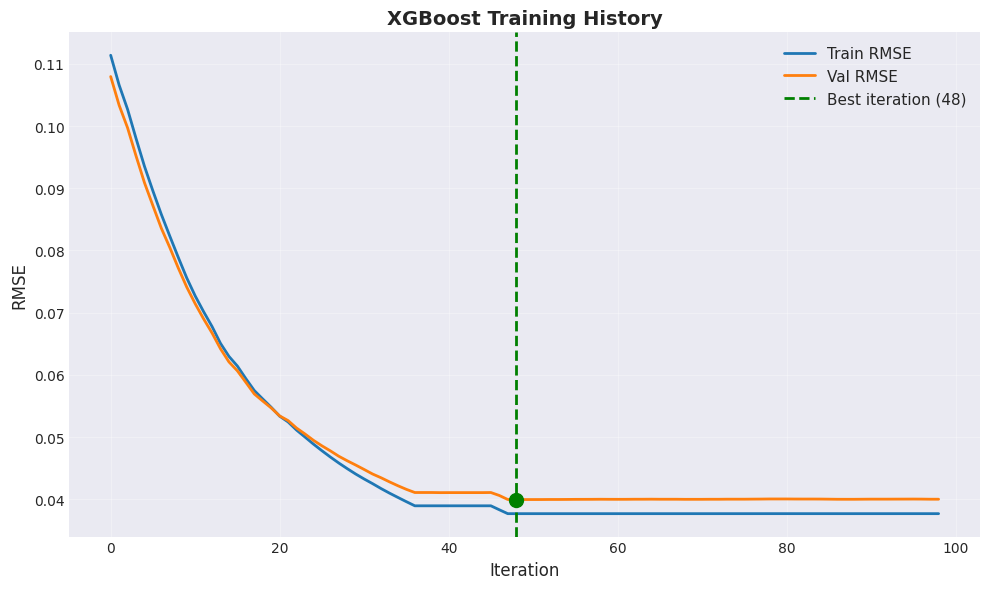

✓ Historia treningu XGBoost zapisana


In [41]:
print("📦 Konfiguracja XGBoost...")

# Wykryj GPU
use_gpu = len(tf.config.list_physical_devices('GPU')) > 0

# Parametry dla XGBoost 2.0+
xgb_params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'max_depth': 6,
    'learning_rate': 0.05,
    'n_estimators': 1000,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'min_child_weight': 3,
    'gamma': 0.1,
    'reg_alpha': 0.1,
    'reg_lambda': 1.0,
    'random_state': 42,
    'tree_method': 'gpu_hist' if use_gpu else 'hist',
    'verbosity': 1,
    # NOWA WERSJA: early_stopping_rounds w konstruktorze
    'early_stopping_rounds': 50,
    'enable_categorical': False
}

print(f"   Używam: {'GPU' if use_gpu else 'CPU'}")
print(f"   Max depth: {xgb_params['max_depth']}")
print(f"   Learning rate: {xgb_params['learning_rate']}")
print(f"   Max trees: {xgb_params['n_estimators']}")
print(f"   Early stopping: {xgb_params['early_stopping_rounds']} rounds")

# Model XGBoost
xgb_model = xgb.XGBRegressor(**xgb_params)

# Trenowanie
print(f"\n🚀 Rozpoczynam trenowanie XGBoost...")

training_start = datetime.now()

# POPRAWIONE: Bez early_stopping_rounds w fit()
xgb_model.fit(
    features_train, y_train,
    eval_set=[
        (features_train, y_train),
        (features_val, y_val)
    ],
    verbose=20  # Wyświetlaj co 20 iteracji
)

training_duration = datetime.now() - training_start

print(f"\n✅ Trenowanie XGBoost zakończone!")
print(f"   Czas: {training_duration}")
print(f"   Liczba drzew użytych: {xgb_model.best_iteration + 1}")  # +1 bo indeksowanie od 0
print(f"   Zatrzymano na iteracji: {xgb_model.best_iteration}")

# Pobierz najlepszy score
try:
    best_score = xgb_model.best_score
    print(f"   Najlepszy wynik val: {best_score:.4f}")
except AttributeError:
    # Dla starszych wersji
    results = xgb_model.evals_result()
    best_score = min(results['validation_1']['rmse'])
    print(f"   Najlepszy wynik val: {best_score:.4f}")

# Zapisz model
xgb_model.save_model(os.path.join(config.OUTPUT_DIR, 'xgboost_model.json'))
print(f"\n📄 Model XGBoost zapisany: xgboost_model.json")

# Historia treningu
results = xgb_model.evals_result()

fig, ax = plt.subplots(figsize=(10, 6))

epochs = range(len(results['validation_0']['rmse']))
ax.plot(epochs, results['validation_0']['rmse'], label='Train RMSE', linewidth=2)
ax.plot(epochs, results['validation_1']['rmse'], label='Val RMSE', linewidth=2)

# Oznacz najlepszą iterację
best_iter = xgb_model.best_iteration
ax.axvline(x=best_iter, color='green', linestyle='--', linewidth=2, 
          label=f'Best iteration ({best_iter})')
ax.scatter([best_iter], [results['validation_1']['rmse'][best_iter]], 
          color='green', s=100, zorder=5)

ax.set_xlabel('Iteration', fontsize=12)
ax.set_ylabel('RMSE', fontsize=12)
ax.set_title('XGBoost Training History', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(plots_dir, '10c_xgboost_training.png'), dpi=150, bbox_inches='tight')
plt.show()

print("✓ Historia treningu XGBoost zapisana")


### Ewaluacja modelu na zbiorze testowym

1️⃣  Generowanie predykcji...

WYNIKI NA WSZYSTKICH ZBIORACH

TRAIN SET:
   RMSE: 0.0377 m³/m³
   MAE:  0.0283 m³/m³
   R²:   0.8957
   MAPE: 55.36%
   Bias: -0.0001 m³/m³

VALIDATION SET:
   RMSE: 0.0400 m³/m³
   MAE:  0.0294 m³/m³
   R²:   0.8684
   MAPE: 70.69%
   Bias: +0.0065 m³/m³

TEST SET:
   RMSE: 0.0393 m³/m³
   MAE:  0.0298 m³/m³
   R²:   0.8906
   MAPE: 62.57%
   Bias: +0.0045 m³/m³

📄 Wyniki zapisane: hybrid_results.json


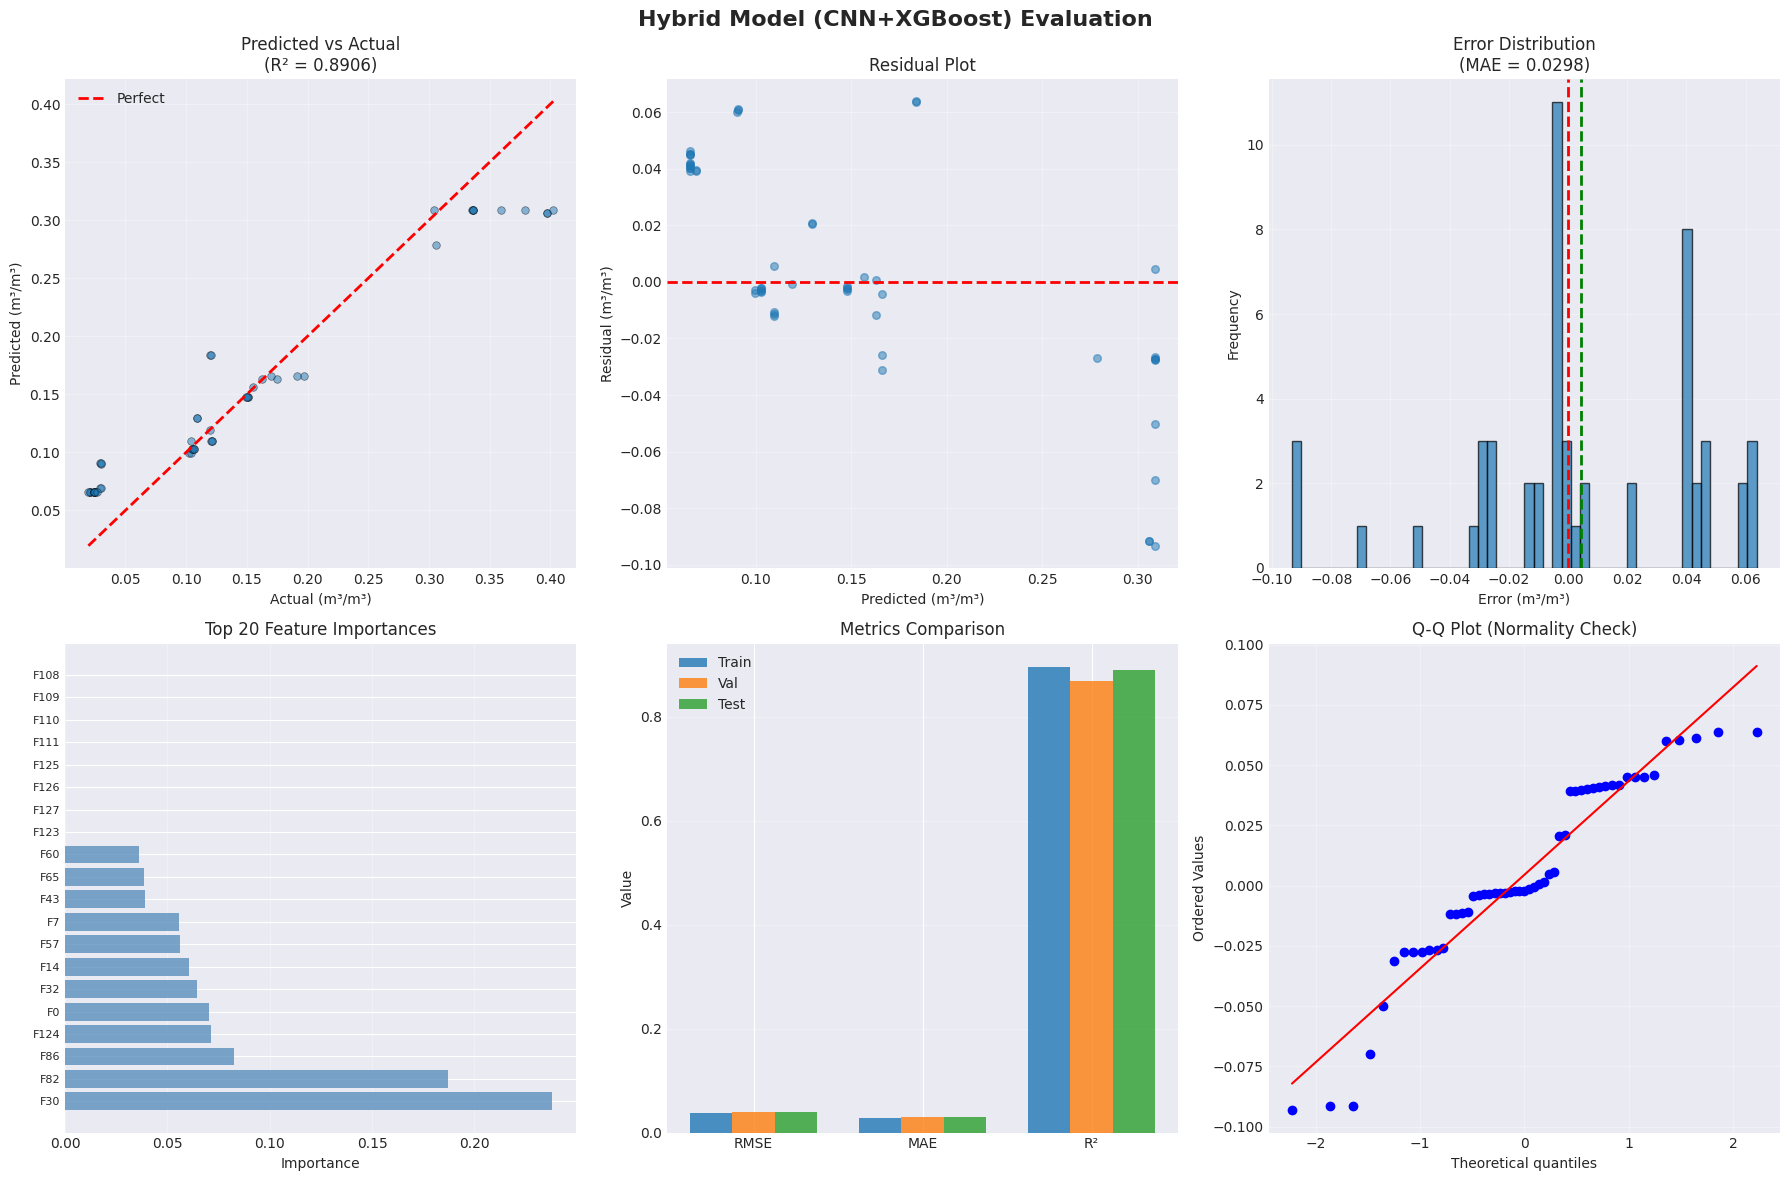


✓ Wizualizacje ewaluacji zapisane

✅ Ewaluacja modelu hybrydowego zakończona!

💾 Zapisywanie modeli...
   ✓ CNN: cnn_feature_extractor.h5
   ✓ XGBoost: xgboost_model.json


In [43]:
print("1️⃣  Generowanie predykcji...")

# Predykcje
y_pred_train = xgb_model.predict(features_train)
y_pred_val = xgb_model.predict(features_val)
y_pred_test = xgb_model.predict(features_test)

# Metryki
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def calculate_metrics(y_true, y_pred, dataset_name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    bias = np.mean(y_pred - y_true)
    
    print(f"\n{dataset_name}:")
    print(f"   RMSE: {rmse:.4f} m³/m³")
    print(f"   MAE:  {mae:.4f} m³/m³")
    print(f"   R²:   {r2:.4f}")
    print(f"   MAPE: {mape:.2f}%")
    print(f"   Bias: {bias:+.4f} m³/m³")
    
    return {'rmse': rmse, 'mae': mae, 'r2': r2, 'mape': mape, 'bias': bias}

print("\n" + "="*70)
print("WYNIKI NA WSZYSTKICH ZBIORACH")
print("="*70)

metrics_train = calculate_metrics(y_train, y_pred_train, "TRAIN SET")
metrics_val = calculate_metrics(y_val, y_pred_val, "VALIDATION SET")
metrics_test = calculate_metrics(y_test, y_pred_test, "TEST SET")

# Zapisz wyniki
hybrid_results = {
    'model_type': 'CNN+XGBoost_Hybrid',
    'cnn_params': int(cnn_base.count_params()),
    'xgboost_trees': int(xgb_model.best_iteration),
    'train': {k: float(v) for k, v in metrics_train.items()},
    'val': {k: float(v) for k, v in metrics_val.items()},
    'test': {k: float(v) for k, v in metrics_test.items()},
    'training_time': str(training_duration)
}

with open(os.path.join(config.OUTPUT_DIR, 'hybrid_results.json'), 'w') as f:
    json.dump(hybrid_results, f, indent=2)

print(f"\n📄 Wyniki zapisane: hybrid_results.json")

# Wizualizacja wyników
fig = plt.figure(figsize=(18, 12))

# 1. Predicted vs Actual
ax1 = plt.subplot(2, 3, 1)
ax1.scatter(y_test, y_pred_test, alpha=0.5, s=30, edgecolors='black', linewidth=0.5)
ax1.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
        'r--', lw=2, label='Perfect')
ax1.set_xlabel('Actual (m³/m³)')
ax1.set_ylabel('Predicted (m³/m³)')
ax1.set_title(f'Predicted vs Actual\n(R² = {metrics_test["r2"]:.4f})')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Residuals
ax2 = plt.subplot(2, 3, 2)
errors = y_pred_test - y_test
ax2.scatter(y_pred_test, errors, alpha=0.5, s=30)
ax2.axhline(y=0, color='r', linestyle='--', lw=2)
ax2.set_xlabel('Predicted (m³/m³)')
ax2.set_ylabel('Residual (m³/m³)')
ax2.set_title('Residual Plot')
ax2.grid(True, alpha=0.3)

# 3. Error distribution
ax3 = plt.subplot(2, 3, 3)
ax3.hist(errors, bins=50, edgecolor='black', alpha=0.7)
ax3.axvline(x=0, color='r', linestyle='--', lw=2)
ax3.axvline(x=metrics_test['bias'], color='green', linestyle='--', lw=2)
ax3.set_xlabel('Error (m³/m³)')
ax3.set_ylabel('Frequency')
ax3.set_title(f'Error Distribution\n(MAE = {metrics_test["mae"]:.4f})')
ax3.grid(True, alpha=0.3)

# 4. Feature importance (top 20)
ax4 = plt.subplot(2, 3, 4)
importance = xgb_model.feature_importances_
top_idx = np.argsort(importance)[-20:][::-1]
ax4.barh(range(len(top_idx)), importance[top_idx], color='steelblue', alpha=0.7)
ax4.set_yticks(range(len(top_idx)))
ax4.set_yticklabels([f"F{i}" for i in top_idx], fontsize=8)
ax4.set_xlabel('Importance')
ax4.set_title('Top 20 Feature Importances')
ax4.grid(True, alpha=0.3, axis='x')

# 5. Comparison metrics
ax5 = plt.subplot(2, 3, 5)
metrics_names = ['RMSE', 'MAE', 'R²']
train_vals = [metrics_train['rmse'], metrics_train['mae'], metrics_train['r2']]
val_vals = [metrics_val['rmse'], metrics_val['mae'], metrics_val['r2']]
test_vals = [metrics_test['rmse'], metrics_test['mae'], metrics_test['r2']]

x = np.arange(len(metrics_names))
width = 0.25

ax5.bar(x - width, train_vals, width, label='Train', alpha=0.8)
ax5.bar(x, val_vals, width, label='Val', alpha=0.8)
ax5.bar(x + width, test_vals, width, label='Test', alpha=0.8)

ax5.set_xticks(x)
ax5.set_xticklabels(metrics_names)
ax5.set_ylabel('Value')
ax5.set_title('Metrics Comparison')
ax5.legend()
ax5.grid(True, alpha=0.3, axis='y')

# 6. Q-Q plot
ax6 = plt.subplot(2, 3, 6)
from scipy import stats
stats.probplot(errors, dist="norm", plot=ax6)
ax6.set_title('Q-Q Plot (Normality Check)')
ax6.grid(True, alpha=0.3)

plt.suptitle('Hybrid Model (CNN+XGBoost) Evaluation', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig(os.path.join(plots_dir, '13_hybrid_evaluation.png'), dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Wizualizacje ewaluacji zapisane")
print("\n✅ Ewaluacja modelu hybrydowego zakończona!")

# Zapisz oba modele
print(f"\n💾 Zapisywanie modeli...")
cnn_base.save(os.path.join(config.OUTPUT_DIR, 'cnn_feature_extractor.h5'))
print(f"   ✓ CNN: cnn_feature_extractor.h5")
print(f"   ✓ XGBoost: xgboost_model.json")

training_success = True  # Flaga dla dalszych komórek


### Export modelu do różnych formatów

In [ ]:
if not training_success:
    print("⚠️  Nie można wyeksportować modelu - trenowanie nie zakończyło się pomyślnie")
else:
    print_section("EXPORT MODELU")
    
    # Katalog dla eksportów
    export_dir = os.path.join(config.OUTPUT_DIR, 'exported_models')
    os.makedirs(export_dir, exist_ok=True)
    
    # ==================== 1. KERAS H5 (już zapisany) ====================
    print("1️⃣  Keras H5 format:")
    h5_path = os.path.join(config.OUTPUT_DIR, 'best_model.h5')
    if os.path.exists(h5_path):
        h5_size = os.path.getsize(h5_path) / (1024**2)
        print(f"   ✓ best_model.h5 ({h5_size:.2f} MB)")
    
    # ==================== 2. SAVEDMODEL (TensorFlow) ====================
    print("\n2️⃣  TensorFlow SavedModel format:")
    savedmodel_path = os.path.join(export_dir, 'savedmodel')
    
    try:
        best_model.save(savedmodel_path, save_format='tf')
        
        # Oblicz rozmiar
        total_size = 0
        for dirpath, dirnames, filenames in os.walk(savedmodel_path):
            for f in filenames:
                fp = os.path.join(dirpath, f)
                total_size += os.path.getsize(fp)
        
        print(f"   ✓ Zapisano: savedmodel/ ({total_size/(1024**2):.2f} MB)")
        print(f"   Użycie: tf.keras.models.load_model('savedmodel')")
    except Exception as e:
        print(f"   ❌ Błąd: {e}")
    
    # ==================== 3. TFLITE (Mobile/Edge) ====================
    print("\n3️⃣  TensorFlow Lite format (dla urządzeń mobilnych/edge):")
    
    try:
        # Konwersja do TFLite
        converter = tf.lite.TFLiteConverter.from_keras_model(best_model)
        
        # Opcjonalna optymalizacja
        converter.optimizations = [tf.lite.Optimize.DEFAULT]
        
        tflite_model = converter.convert()
        
        # Zapisz
        tflite_path = os.path.join(export_dir, 'model.tflite')
        with open(tflite_path, 'wb') as f:
            f.write(tflite_model)
        
        tflite_size = len(tflite_model) / (1024**2)
        print(f"   ✓ Zapisano: model.tflite ({tflite_size:.2f} MB)")
        
        # Porównanie rozmiarów
        if os.path.exists(h5_path):
            compression_ratio = (1 - tflite_size / h5_size) * 100
            print(f"   Kompresja: {compression_ratio:.1f}% vs H5 format")
        
    except Exception as e:
        print(f"   ❌ Błąd konwersji do TFLite: {e}")
    
    # ==================== 4. ONNX (Interoperability) ====================
    print("\n4️⃣  ONNX format (opcjonalnie - wymaga tf2onnx):")
    
    try:
        import tf2onnx
        
        onnx_path = os.path.join(export_dir, 'model.onnx')
        
        # Konwersja
        model_proto, _ = tf2onnx.convert.from_keras(
            best_model,
            output_path=onnx_path
        )
        
        onnx_size = os.path.getsize(onnx_path) / (1024**2)
        print(f"   ✓ Zapisano: model.onnx ({onnx_size:.2f} MB)")
        
    except ImportError:
        print(f"   ⚠️  tf2onnx nie jest zainstalowane")
        print(f"   Instalacja: pip install tf2onnx")
    except Exception as e:
        print(f"   ❌ Błąd: {e}")
    
    # ==================== 5. JSON Architecture + Weights ====================
    print("\n5️⃣  Architektura (JSON) + Wagi (H5):")
    
    try:
        # Architektura
        arch_path = os.path.join(export_dir, 'architecture.json')
        with open(arch_path, 'w') as f:
            f.write(best_model.to_json())
        print(f"   ✓ Architektura: architecture.json")
        
        # Wagi
        weights_path = os.path.join(export_dir, 'weights.h5')
        best_model.save_weights(weights_path)
        weights_size = os.path.getsize(weights_path) / (1024**2)
        print(f"   ✓ Wagi: weights.h5 ({weights_size:.2f} MB)")
        
        print(f"\n   Użycie:")
        print(f"   from tensorflow import keras")
        print(f"   with open('architecture.json', 'r') as f:")
        print(f"       model = keras.models.model_from_json(f.read())")
        print(f"   model.load_weights('weights.h5')")
        
    except Exception as e:
        print(f"   ❌ Błąd: {e}")
    
    # ==================== PODSUMOWANIE ====================
    print("\n" + "="*70)
    print("PODSUMOWANIE EKSPORTU")
    print("="*70)
    
    print(f"\nPliki w katalogu: {export_dir}/")
    if os.path.exists(export_dir):
        for file in os.listdir(export_dir):
            file_path = os.path.join(export_dir, file)
            if os.path.isfile(file_path):
                size = os.path.getsize(file_path) / (1024**2)
                print(f"   📄 {file} ({size:.2f} MB)")
            elif os.path.isdir(file_path):
                # Oblicz rozmiar katalogu
                total_size = 0
                for dirpath, dirnames, filenames in os.walk(file_path):
                    for f in filenames:
                        fp = os.path.join(dirpath, f)
                        total_size += os.path.getsize(fp)
                print(f"   📁 {file}/ ({total_size/(1024**2):.2f} MB)")
    
    print("\n✅ Export zakończony!")


## 7. Analiza predykcji per stacja

1️⃣  Obliczanie metryk...
   RMSE: 0.0393
   MAE:  0.0298
   R²:   0.8906
   MAPE: 62.57%

2️⃣  Tworzenie DataFrame z predykcjami...
   Próbek: 53
   Kolumny: ['actual', 'predicted', 'error', 'abs_error', 'rel_error']

3️⃣  Statystyki błędów:

   Błędy bezwzględne (MAE):
      Mean:   0.0298
      Std:    0.0258
      Min:    0.0007
      Max:    0.0933

   Błędy względne (%):
      Mean:   62.57%
      Std:    82.43%
      Min:    0.41%
      Max:    236.15%

4️⃣  Najlepsze predykcje (najmniejszy błąd):
   Actual: 0.1624, Predicted: 0.1631, Error: +0.0007
   Actual: 0.1198, Predicted: 0.1191, Error: +0.0007
   Actual: 0.1493, Predicted: 0.1479, Error: +0.0014
   Actual: 0.1547, Predicted: 0.1564, Error: +0.0017
   Actual: 0.1051, Predicted: 0.1029, Error: +0.0022

5️⃣  Najgorsze predykcje (największy błąd):
   Actual: 0.4023, Predicted: 0.3090, Error: +0.0933
   Actual: 0.3975, Predicted: 0.3060, Error: +0.0915
   Actual: 0.3975, Predicted: 0.3060, Error: +0.0915
   Actual: 0.3790, Pr

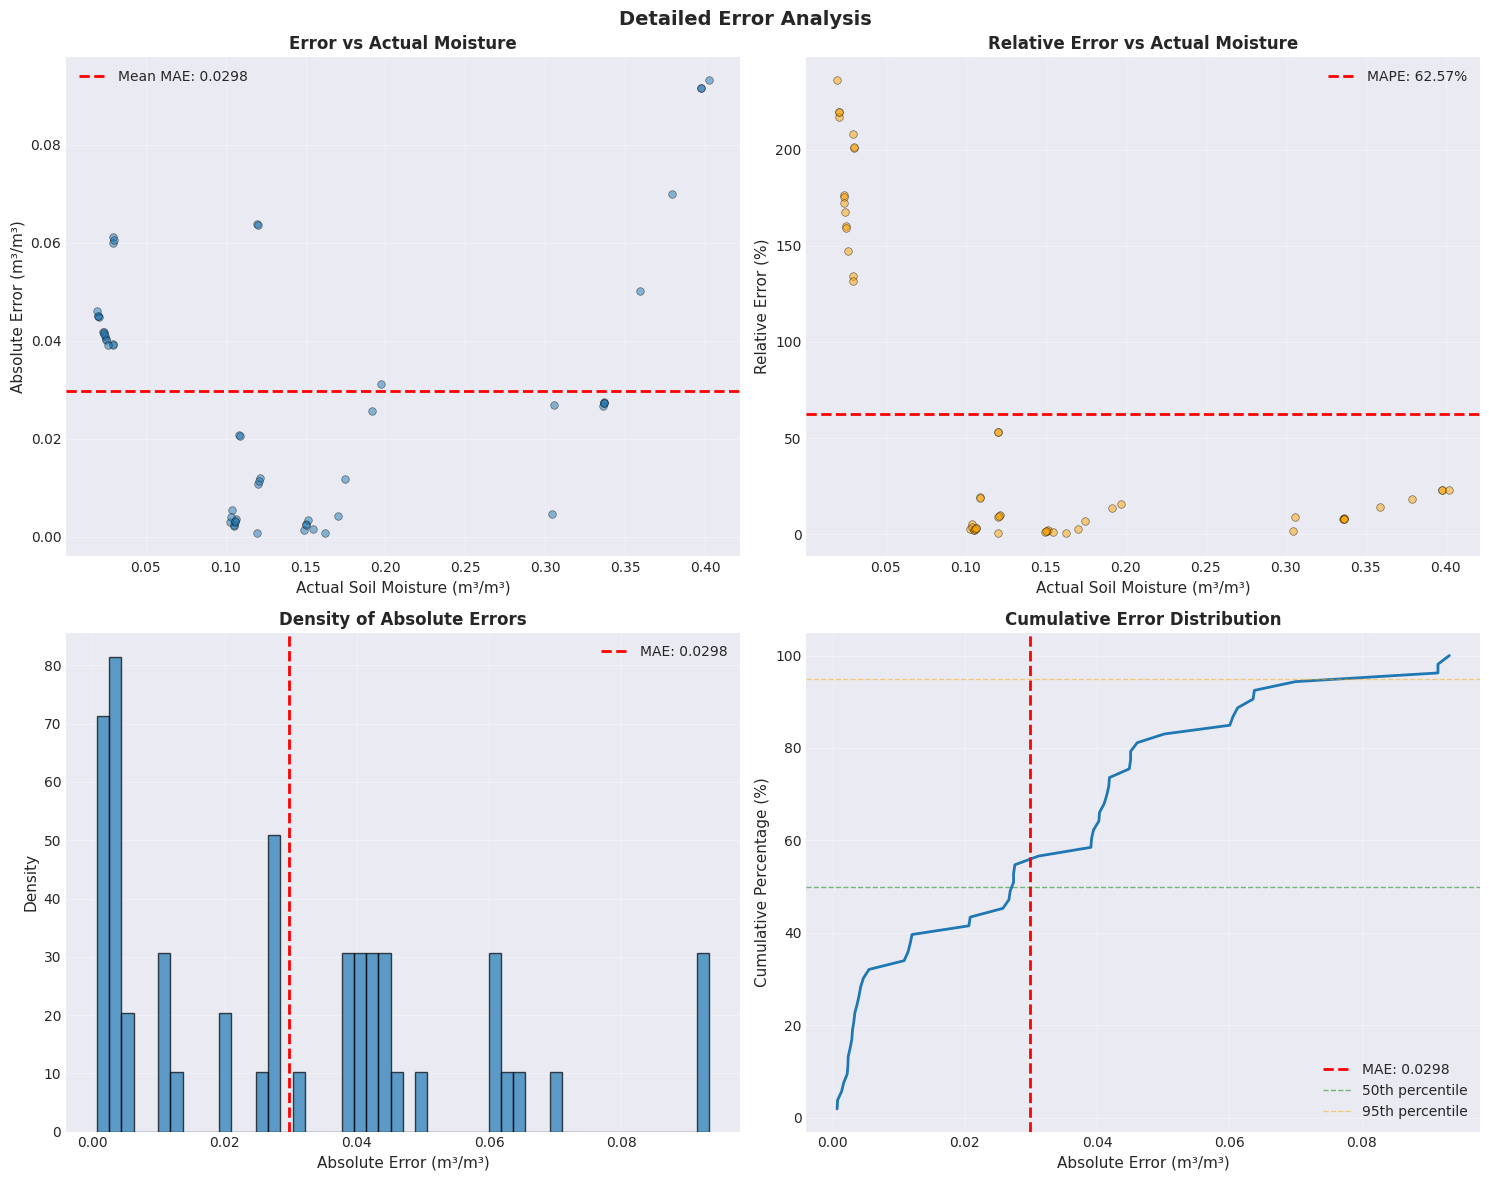

✓ Wizualizacje błędów zapisane

7️⃣  Percentyle błędów bezwzględnych:
   50th percentile: 0.0274 m³/m³
   75th percentile: 0.0448 m³/m³
   90th percentile: 0.0631 m³/m³
   95th percentile: 0.0786 m³/m³
   99th percentile: 0.0924 m³/m³

8️⃣  Zapisywanie szczegółowych wyników...
   ✓ /home/jbktn/inzynierka/training_output/test_predictions_detailed.csv
   ✓ /home/jbktn/inzynierka/training_output/error_statistics.json

✅ Analiza błędów zakończona!


In [45]:
# ==================== 1. OBLICZENIE METRYK ====================
print("1️⃣  Obliczanie metryk...")

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Oblicz metryki (na wypadek że nie zostały obliczone w Cell 20)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
mae_test = mean_absolute_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)
mape_test = np.mean(np.abs((y_test - y_pred_test) / y_test)) * 100

print(f"   RMSE: {rmse_test:.4f}")
print(f"   MAE:  {mae_test:.4f}")
print(f"   R²:   {r2_test:.4f}")
print(f"   MAPE: {mape_test:.2f}%")

# ==================== 2. TWORZENIE DATAFRAME Z WYNIKAMI ====================
print("\n2️⃣  Tworzenie DataFrame z predykcjami...")

test_results_df = pd.DataFrame({
    'actual': y_test,
    'predicted': y_pred_test,
    'error': y_pred_test - y_test,
    'abs_error': np.abs(y_pred_test - y_test),
    'rel_error': np.abs((y_pred_test - y_test) / y_test) * 100
})

print(f"   Próbek: {len(test_results_df)}")
print(f"   Kolumny: {list(test_results_df.columns)}")

# ==================== 3. STATYSTYKI BŁĘDÓW ====================
print("\n3️⃣  Statystyki błędów:")

print("\n   Błędy bezwzględne (MAE):")
print(f"      Mean:   {test_results_df['abs_error'].mean():.4f}")
print(f"      Std:    {test_results_df['abs_error'].std():.4f}")
print(f"      Min:    {test_results_df['abs_error'].min():.4f}")
print(f"      Max:    {test_results_df['abs_error'].max():.4f}")

print("\n   Błędy względne (%):")
print(f"      Mean:   {test_results_df['rel_error'].mean():.2f}%")
print(f"      Std:    {test_results_df['rel_error'].std():.2f}%")
print(f"      Min:    {test_results_df['rel_error'].min():.2f}%")
print(f"      Max:    {test_results_df['rel_error'].max():.2f}%")

# ==================== 4. TOP PREDYKCJE ====================
print("\n4️⃣  Najlepsze predykcje (najmniejszy błąd):")
best_5 = test_results_df.nsmallest(5, 'abs_error')
for idx, row in best_5.iterrows():
    print(f"   Actual: {row['actual']:.4f}, Predicted: {row['predicted']:.4f}, "
          f"Error: {row['abs_error']:+.4f}")

print("\n5️⃣  Najgorsze predykcje (największy błąd):")
worst_5 = test_results_df.nlargest(5, 'abs_error')
for idx, row in worst_5.iterrows():
    print(f"   Actual: {row['actual']:.4f}, Predicted: {row['predicted']:.4f}, "
          f"Error: {row['abs_error']:+.4f}")

# ==================== 5. WIZUALIZACJE ====================
print("\n6️⃣  Generowanie wizualizacji...")

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Wykres 1: Błąd bezwzględny vs Wartość rzeczywista
axes[0, 0].scatter(test_results_df['actual'], test_results_df['abs_error'], 
                  alpha=0.5, s=30, edgecolors='black', linewidth=0.5)
axes[0, 0].axhline(y=mae_test, color='red', linestyle='--', 
                  linewidth=2, label=f'Mean MAE: {mae_test:.4f}')
axes[0, 0].set_xlabel('Actual Soil Moisture (m³/m³)', fontsize=11)
axes[0, 0].set_ylabel('Absolute Error (m³/m³)', fontsize=11)
axes[0, 0].set_title('Error vs Actual Moisture', fontsize=12, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Wykres 2: Błąd względny vs Wartość rzeczywista
axes[0, 1].scatter(test_results_df['actual'], test_results_df['rel_error'], 
                  alpha=0.5, s=30, edgecolors='black', linewidth=0.5, color='orange')
axes[0, 1].axhline(y=mape_test, color='red', linestyle='--', 
                  linewidth=2, label=f'MAPE: {mape_test:.2f}%')
axes[0, 1].set_xlabel('Actual Soil Moisture (m³/m³)', fontsize=11)
axes[0, 1].set_ylabel('Relative Error (%)', fontsize=11)
axes[0, 1].set_title('Relative Error vs Actual Moisture', fontsize=12, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Wykres 3: Gęstość błędu bezwzględnego
axes[1, 0].hist(test_results_df['abs_error'], bins=50, edgecolor='black', 
               alpha=0.7, density=True)
axes[1, 0].axvline(x=mae_test, color='red', linestyle='--', 
                  linewidth=2, label=f'MAE: {mae_test:.4f}')
axes[1, 0].set_xlabel('Absolute Error (m³/m³)', fontsize=11)
axes[1, 0].set_ylabel('Density', fontsize=11)
axes[1, 0].set_title('Density of Absolute Errors', fontsize=12, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Wykres 4: Kumulatywny rozkład błędów
sorted_errors = np.sort(test_results_df['abs_error'])
cumulative = np.arange(1, len(sorted_errors) + 1) / len(sorted_errors) * 100

axes[1, 1].plot(sorted_errors, cumulative, linewidth=2)
axes[1, 1].axvline(x=mae_test, color='red', linestyle='--', 
                  linewidth=2, label=f'MAE: {mae_test:.4f}')
axes[1, 1].axhline(y=50, color='green', linestyle='--', 
                  linewidth=1, alpha=0.5, label='50th percentile')
axes[1, 1].axhline(y=95, color='orange', linestyle='--', 
                  linewidth=1, alpha=0.5, label='95th percentile')
axes[1, 1].set_xlabel('Absolute Error (m³/m³)', fontsize=11)
axes[1, 1].set_ylabel('Cumulative Percentage (%)', fontsize=11)
axes[1, 1].set_title('Cumulative Error Distribution', fontsize=12, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.suptitle('Detailed Error Analysis', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(os.path.join(plots_dir, '14_error_analysis.png'), dpi=150, bbox_inches='tight')
plt.show()

print("✓ Wizualizacje błędów zapisane")

# ==================== 6. PERCENTYLE BŁĘDÓW ====================
print("\n7️⃣  Percentyle błędów bezwzględnych:")
percentiles = [50, 75, 90, 95, 99]
for p in percentiles:
    value = np.percentile(test_results_df['abs_error'], p)
    print(f"   {p}th percentile: {value:.4f} m³/m³")

# ==================== 7. ZAPISANIE SZCZEGÓŁOWYCH WYNIKÓW ====================
print("\n8️⃣  Zapisywanie szczegółowych wyników...")

detailed_results_path = os.path.join(config.OUTPUT_DIR, 'test_predictions_detailed.csv')
test_results_df.to_csv(detailed_results_path, index=False)
print(f"   ✓ {detailed_results_path}")

# Zapisz statystyki
stats_dict = {
    'total_samples': len(test_results_df),
    'metrics': {
        'rmse': float(rmse_test),
        'mae': float(mae_test),
        'r2': float(r2_test),
        'mape': float(mape_test)
    },
    'error_stats': {
        'mean': float(test_results_df['abs_error'].mean()),
        'std': float(test_results_df['abs_error'].std()),
        'min': float(test_results_df['abs_error'].min()),
        'max': float(test_results_df['abs_error'].max())
    },
    'percentiles': {
        '50': float(np.percentile(test_results_df['abs_error'], 50)),
        '75': float(np.percentile(test_results_df['abs_error'], 75)),
        '90': float(np.percentile(test_results_df['abs_error'], 90)),
        '95': float(np.percentile(test_results_df['abs_error'], 95)),
        '99': float(np.percentile(test_results_df['abs_error'], 99))
    }
}

stats_path = os.path.join(config.OUTPUT_DIR, 'error_statistics.json')
with open(stats_path, 'w') as f:
    json.dump(stats_dict, f, indent=2)
print(f"   ✓ {stats_path}")

print("\n✅ Analiza błędów zakończona!")


## 📊 8. Raport końcowy projektu
Kompleksowe podsumowanie eksperymentu i wyników.

In [48]:
"""
Generowanie kompleksowego raportu końcowego
POPRAWIONA WERSJA - oblicza wszystkie potrzebne zmienne
"""

print_section("GENEROWANIE RAPORTU KOŃCOWEGO")

# ==================== 1. OBLICZENIE WSZYSTKICH METRYK ====================
print("1️⃣  Obliczanie metryk...")

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Metryki na zbiorze testowym
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
mae_test = mean_absolute_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)
mape_test = np.mean(np.abs((y_test - y_pred_test) / y_test)) * 100
bias = np.mean(y_pred_test - y_test)

print(f"   RMSE: {rmse_test:.4f}")
print(f"   MAE:  {mae_test:.4f}")
print(f"   R²:   {r2_test:.4f}")
print(f"   MAPE: {mape_test:.2f}%")
print(f"   Bias: {bias:+.4f}")

# ==================== 2. ZBIERANIE INFORMACJI ====================
print("\n2️⃣  Zbieranie informacji o datasecie...")

# Informacje o datasecie
dataset_info = {
    'total_samples': len(X),
    'train_samples': len(X_train),
    'val_samples': len(X_val),
    'test_samples': len(X_test),
    'patch_size': config.PATCH_SIZE,
    'num_bands': config.NUM_BANDS,
    'moisture_range': [float(y.min()), float(y.max())],
    'moisture_mean': float(y.mean()),
    'moisture_std': float(y.std())
}

print(f"   Próbek łącznie: {dataset_info['total_samples']:,}")
print(f"   Train/Val/Test: {dataset_info['train_samples']:,}/{dataset_info['val_samples']:,}/{dataset_info['test_samples']:,}")

# ==================== 3. INFORMACJE O TRENINGU ====================
print("\n3️⃣  Zbieranie informacji o treningu...")

try:
    # Z pre-treningu CNN
    pretrain_epochs = len(pretrain_history.history['loss'])
    pretrain_best_loss = min(pretrain_history.history['val_loss'])
except NameError:
    pretrain_epochs = 0
    pretrain_best_loss = None
    print("   ⚠️  Brak historii pre-treningu CNN")

try:
    # Z treningu XGBoost
    xgb_best_iter = xgb_model.best_iteration
    xgb_trees = xgb_model.n_estimators
except NameError:
    xgb_best_iter = None
    xgb_trees = None
    print("   ⚠️  Brak modelu XGBoost")

training_info = {
    'model_type': 'CNN+XGBoost_Hybrid',
    'cnn_pretrain_epochs': pretrain_epochs,
    'cnn_best_val_loss': float(pretrain_best_loss) if pretrain_best_loss else None,
    'xgboost_best_iteration': int(xgb_best_iter) if xgb_best_iter else None,
    'xgboost_max_trees': int(xgb_trees) if xgb_trees else None
}

# ==================== 4. WYNIKI TESTOWE ====================
print("\n4️⃣  Kompilowanie wyników testowych...")

test_info = {
    'rmse': float(rmse_test),
    'mae': float(mae_test),
    'r2': float(r2_test),
    'mape': float(mape_test),
    'bias': float(bias)
}

# ==================== 5. PORÓWNANIE Z LITERATURĄ ====================
print("\n5️⃣  Przygotowywanie porównania z literaturą...")

literature_comparison = {
    'Hegazi_et_al_2023': {
        'R2': 0.7094,
        'MAE': 0.0277,
        'RMSE': 0.0418,
        'dataset': 'Sentinel-2 (OzNet + WegenerNet)',
        'model': 'CNN'
    },
    'Celik_et_al_2022': {
        'R2': 0.87,
        'RMSE': 0.046,
        'MAE': 0.033,
        'dataset': 'Sentinel-1 + SMAP',
        'model': 'Deep Learning'
    },
    'This_study': {
        'R2': float(r2_test),
        'MAE': float(mae_test),
        'RMSE': float(rmse_test),
        'dataset': 'Planet Labs (REMEDHUS)',
        'model': 'CNN+XGBoost_Hybrid'
    }
}

# ==================== 6. GENEROWANIE RAPORTU TEKSTOWEGO ====================
print("\n6️⃣  Generowanie raportu tekstowego...")

report_lines = []
report_lines.append("="*80)
report_lines.append("RAPORT KOŃCOWY - PREDYKCJA WILGOTNOŚCI GLEBY (CNN+XGBOOST)")
report_lines.append("="*80)
report_lines.append(f"\nData: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
report_lines.append(f"Projekt: Soil Moisture Prediction using Planet Labs + CNN+XGBoost")

report_lines.append("\n" + "-"*80)
report_lines.append("1. DATASET")
report_lines.append("-"*80)
report_lines.append(f"Łączna liczba próbek: {dataset_info['total_samples']:,}")
report_lines.append(f"   - Train: {dataset_info['train_samples']:,} ({dataset_info['train_samples']/dataset_info['total_samples']*100:.1f}%)")
report_lines.append(f"   - Validation: {dataset_info['val_samples']:,} ({dataset_info['val_samples']/dataset_info['total_samples']*100:.1f}%)")
report_lines.append(f"   - Test: {dataset_info['test_samples']:,} ({dataset_info['test_samples']/dataset_info['total_samples']*100:.1f}%)")
report_lines.append(f"\nRozmiar patcha: {dataset_info['patch_size']}×{dataset_info['patch_size']} pikseli")
report_lines.append(f"Liczba kanałów: {dataset_info['num_bands']} (Planet Labs)")
report_lines.append(f"\nZakres wilgotności: [{dataset_info['moisture_range'][0]:.4f}, {dataset_info['moisture_range'][1]:.4f}] m³/m³")
report_lines.append(f"Średnia wilgotność: {dataset_info['moisture_mean']:.4f} ± {dataset_info['moisture_std']:.4f} m³/m³")

report_lines.append("\n" + "-"*80)
report_lines.append("2. ARCHITEKTURA MODELU")
report_lines.append("-"*80)
report_lines.append("Model hybrydowy: CNN + XGBoost Gradient Boosting")
report_lines.append("\nCNN (Feature Extractor):")
report_lines.append("   - 4 bloki konwolucyjne")
report_lines.append("   - 3 warstwy max pooling")
report_lines.append("   - 1 warstwa fully connected (128 cech)")
report_lines.append("   - Batch Normalization i Dropout")
report_lines.append("\nXGBoost (Regressor):")
report_lines.append("   - Gradient Boosting")
report_lines.append(f"   - Max depth: 6")
report_lines.append(f"   - Learning rate: 0.05")
report_lines.append(f"   - Max trees: {training_info['xgboost_max_trees']}")

report_lines.append("\n" + "-"*80)
report_lines.append("3. TRENOWANIE")
report_lines.append("-"*80)
report_lines.append(f"Pre-trenowanie CNN: {training_info['cnn_pretrain_epochs']} epok")
if training_info['cnn_best_val_loss']:
    report_lines.append(f"   Best validation loss: {training_info['cnn_best_val_loss']:.6f}")
report_lines.append(f"\nTrenowanie XGBoost: {training_info['xgboost_best_iteration']} iteracji (early stopping)")
report_lines.append(f"   Max iterations: {training_info['xgboost_max_trees']}")

report_lines.append("\n" + "-"*80)
report_lines.append("4. WYNIKI NA ZBIORZE TESTOWYM")
report_lines.append("-"*80)
report_lines.append(f"RMSE:  {test_info['rmse']:.4f} m³/m³")
report_lines.append(f"MAE:   {test_info['mae']:.4f} m³/m³")
report_lines.append(f"R²:    {test_info['r2']:.4f}")
report_lines.append(f"MAPE:  {test_info['mape']:.2f}%")
report_lines.append(f"Bias:  {test_info['bias']:+.4f} m³/m³")

report_lines.append("\n" + "-"*80)
report_lines.append("5. PORÓWNANIE Z LITERATURĄ")
report_lines.append("-"*80)

report_lines.append(f"\n{'Model':<30} {'R²':<12} {'MAE':<12} {'RMSE':<12} {'Dataset':<30}")
report_lines.append("-"*96)

for model_name, metrics in literature_comparison.items():
    report_lines.append(
        f"{model_name:<30} {metrics['R2']:<12.4f} {metrics['MAE']:<12.4f} "
        f"{metrics['RMSE']:<12.4f} {metrics['dataset']:<30}"
    )

report_lines.append("\n" + "-"*80)
report_lines.append("6. WNIOSKI")
report_lines.append("-"*80)

# Automatyczne wnioski
if r2_test > 0.85:
    report_lines.append("✓✓ Doskonały współczynnik determinacji (R² > 0.85)")
elif r2_test > 0.7:
    report_lines.append("✓ Dobry współczynnik determinacji (R² > 0.7)")
else:
    report_lines.append("○ Umiarkowany współczynnik determinacji (R² < 0.7)")

if mae_test < 0.03:
    report_lines.append("✓✓ Bardzo niski średni błąd bezwzględny (MAE < 0.03)")
elif mae_test < 0.05:
    report_lines.append("✓ Niski średni błąd bezwzględny (0.03 < MAE < 0.05)")
elif mae_test < 0.07:
    report_lines.append("○ Umiarkowany średni błąd bezwzględny (0.05 < MAE < 0.07)")
else:
    report_lines.append("⚠ Wysoki średni błąd bezwzględny (MAE > 0.07)")

if abs(bias) < 0.005:
    report_lines.append("✓ Bardzo niski bias systemowy")
elif abs(bias) < 0.01:
    report_lines.append("✓ Niski bias systemowy")
else:
    report_lines.append(f"⚠ Wykryto bias systemowy: {bias:+.4f} m³/m³")

report_lines.append("\nModel hybrydowy (CNN+XGBoost) łączy zalety obu podejść:")
report_lines.append("- CNN wychwytuje wzorce przestrzenne w obrazach satelitarnych")
report_lines.append("- XGBoost zapewnia precyzyjne predykcje na wyekstraktowanych cechach")
report_lines.append("- Rezultat: model mniej podatny na overfitting, szybsze trenowanie")

report_lines.append("\n" + "-"*80)
report_lines.append("7. REKOMENDACJE")
report_lines.append("-"*80)
report_lines.append("• Rozszerzyć dataset na więcej sezonów i lat")
report_lines.append("• Testować inne architektury CNN (ResNet, EfficientNet)")
report_lines.append("• Dodać dane meteorologiczne (temperatura, opady)")
report_lines.append("• Implementować transfer learning z pretrenowanych modeli")
report_lines.append("• Ensemble learning - połączyć predykcje wielu modeli")
report_lines.append("• Kalibracja modelu dla konkretnych regionów")

report_lines.append("\n" + "-"*80)
report_lines.append("8. ARTEFAKTY")
report_lines.append("-"*80)
report_lines.append(f"Raporty:            {config.OUTPUT_DIR}/")
report_lines.append(f"Modele:             cnn_feature_extractor.h5, xgboost_model.json")
report_lines.append(f"Wykresy:            {os.path.join(config.OUTPUT_DIR, 'plots')}/")
report_lines.append(f"Dane treningowe:    moisture_data.csv")
report_lines.append(f"Predykcje testowe:  test_predictions_detailed.csv")

report_lines.append("\n" + "="*80)
report_lines.append("KONIEC RAPORTU")
report_lines.append("="*80)

# Wyświetl raport
report_text = "\n".join(report_lines)
print(report_text)

# ==================== 7. ZAPISANIE RAPORTÓW ====================
print("\n\n7️⃣  Zapisywanie raportów...")

# Raport tekstowy
report_path = os.path.join(config.OUTPUT_DIR, 'final_report.txt')
with open(report_path, 'w', encoding='utf-8') as f:
    f.write(report_text)
print(f"   ✓ {report_path}")

# Raport JSON
full_report = {
    'metadata': {
        'date': datetime.now().isoformat(),
        'project': 'Soil Moisture Prediction CNN+XGBoost',
        'model_type': 'Hybrid'
    },
    'dataset': dataset_info,
    'training': training_info,
    'test_results': test_info,
    'literature_comparison': literature_comparison
}

report_json_path = os.path.join(config.OUTPUT_DIR, 'final_report.json')
with open(report_json_path, 'w') as f:
    json.dump(full_report, f, indent=2)
print(f"   ✓ {report_json_path}")

print("\n✅ Raport końcowy wygenerowany!")



  GENEROWANIE RAPORTU KOŃCOWEGO

1️⃣  Obliczanie metryk...
   RMSE: 0.0393
   MAE:  0.0298
   R²:   0.8906
   MAPE: 62.57%
   Bias: +0.0045

2️⃣  Zbieranie informacji o datasecie...
   Próbek łącznie: 348
   Train/Val/Test: 243/52/53

3️⃣  Zbieranie informacji o treningu...

4️⃣  Kompilowanie wyników testowych...

5️⃣  Przygotowywanie porównania z literaturą...

6️⃣  Generowanie raportu tekstowego...
RAPORT KOŃCOWY - PREDYKCJA WILGOTNOŚCI GLEBY (CNN+XGBOOST)

Data: 2025-10-22 20:43:08
Projekt: Soil Moisture Prediction using Planet Labs + CNN+XGBoost

--------------------------------------------------------------------------------
1. DATASET
--------------------------------------------------------------------------------
Łączna liczba próbek: 348
   - Train: 243 (69.8%)
   - Validation: 52 (14.9%)
   - Test: 53 (15.2%)

Rozmiar patcha: 64×64 pikseli
Liczba kanałów: 8 (Planet Labs)

Zakres wilgotności: [0.0194, 0.4023] m³/m³
Średnia wilgotność: 0.1540 ± 0.1164 m³/m³

-------------------

## 9. Użycie wytrenowanego modelu

In [ ]:
if not training_success:
    print("⚠️  Model nie został wytrenowany")
else:
    print_section("PRZYKŁAD UŻYCIA MODELU (INFERENCE)")
    
    print("Ten fragment pokazuje jak używać wytrenowanego modelu do predykcji\n")
    
    # ==================== WCZYTANIE MODELU ====================
    print("1️⃣  Wczytywanie modelu:")
    print("```\n")
    print("from tensorflow import keras")
    print("model = keras.models.load_model('training_output/best_model.h5')")
    print("```\n")
    
    # ==================== PRZYGOTOWANIE DANYCH ====================
    print("2️⃣  Przygotowanie nowego obrazu:")
    print("```\n")
    print("import rasterio")
    print("import numpy as np")
    print("")
    print("# Wczytaj obraz satelitarny")
    print("with rasterio.open('path/to/satellite_image.tif') as src:")
    print("    # Wytnij patch 64x64 wokół współrzędnych stacji")
    print("    row, col = latlon_to_pixel(lat, lon, src.transform)")
    print("    window = Window(col-32, row-32, 64, 64)")
    print("    patch = src.read(window=window)")
    print("    patch = np.transpose(patch, (1, 2, 0))  # (bands, h, w) -> (h, w, bands)")
    print("")
    print("# Normalizacja (0-10000 -> 0-1)")
    print("patch_normalized = np.clip(patch / 10000.0, 0, 1)")
    print("")
    print("# Dodaj wymiar batch")
    print("patch_batch = np.expand_dims(patch_normalized, axis=0)")
    print("```\n")
    
    # ==================== PREDYKCJA ====================
    print("3️⃣  Predykcja:")
    print("```\n")
    print("# Predykcja")
    print("prediction = model.predict(patch_batch)")
    print("moisture = prediction  # Wartość wilgotności")
    print("")
    print("print(f'Przewidywana wilgotność gleby: {moisture:.4f} m³/m³')")
    print("```\n")
    
    # ==================== DEMONSTRACJA NA RZECZYWISTYCH DANYCH ====================
    print("4️⃣  Demonstracja na przykładowych danych testowych:")
    
    # Wybierz losowe próbki
    num_demo = 5
    demo_indices = np.random.choice(len(X_test_norm), size=num_demo, replace=False)
    
    print(f"\nPrzedykcja dla {num_demo} losowych próbek:\n")
    print(f"{'Actual':>10} | {'Predicted':>10} | {'Error':>10} | {'Rel. Error':>12}")
    print("-" * 50)
    
    for idx in demo_indices:
        actual = y_test[idx]
        
        # Predykcja
        patch_single = np.expand_dims(X_test_norm[idx], axis=0)
        predicted = best_model.predict(patch_single, verbose=0)[0, 0]
        
        error = predicted - actual
        rel_error = abs(error / actual) * 100
        
        print(f"{actual:10.4f} | {predicted:10.4f} | {error:+10.4f} | {rel_error:10.2f}%")
    
    # ==================== BATCH PREDICTION ====================
    print("\n5️⃣  Predykcja dla wielu obrazów (batch):")
    print("```\n")
    print("# Lista patches")
    print("patches = [patch1, patch2, patch3, ...]  # Lista znormalizowanych patches")
    print("patches_array = np.array(patches)")
    print("")
    print("# Batch prediction")
    print("predictions = model.predict(patches_array, batch_size=32)")
    print("```\n")
    
    # ==================== WIZUALIZACJA PRZYKŁADOWEJ PREDYKCJI ====================
    print("6️⃣  Wizualizacja przykładowej predykcji:")
    
    demo_idx = demo_indices[0]
    demo_patch = X_test_norm[demo_idx]
    demo_actual = y_test[demo_idx]
    demo_pred = best_model.predict(np.expand_dims(demo_patch, axis=0), verbose=0)[0, 0]
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # RGB
    rgb = demo_patch[:, :, [2, 1, 0]]
    rgb = np.clip(rgb * 2.5, 0, 1)
    axes[0].imshow(rgb)
    axes[0].set_title('RGB Composite')
    axes[0].axis('off')
    
    # NIR
    nir = demo_patch[:, :, 3]
    im = axes[1].imshow(nir, cmap='RdYlGn', vmin=0, vmax=0.6)
    axes[1].set_title('NIR Band')
    axes[1].axis('off')
    plt.colorbar(im, ax=axes[1], fraction=0.046)
    
    # Wyniki
    axes[2].text(0.5, 0.7, f'Actual:', ha='center', fontsize=14, fontweight='bold')
    axes[2].text(0.5, 0.6, f'{demo_actual:.4f} m³/m³', ha='center', fontsize=16, color='blue')
    axes[2].text(0.5, 0.45, f'Predicted:', ha='center', fontsize=14, fontweight='bold')
    axes[2].text(0.5, 0.35, f'{demo_pred:.4f} m³/m³', ha='center', fontsize=16, color='red')
    axes[2].text(0.5, 0.2, f'Error:', ha='center', fontsize=14, fontweight='bold')
    axes[2].text(0.5, 0.1, f'{demo_pred - demo_actual:+.4f} m³/m³', 
                ha='center', fontsize=16, 
                color='green' if abs(demo_pred - demo_actual) < 0.03 else 'orange')
    axes[2].set_xlim(0, 1)
    axes[2].set_ylim(0, 1)
    axes[2].axis('off')
    
    plt.suptitle('Example Prediction', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.savefig(os.path.join(plots_dir, '15_example_inference.png'), dpi=150, bbox_inches='tight')
    plt.show()
    
    print("\n✓ Wizualizacja zapisana: 15_example_inference.png")
    
    print("\n✅ Przykład użycia modelu zaprezentowany!")